# 1 概述

下面是一个典型的两层LSTM模型，这样一个RNN模型有一个非常大的缺点：不能并行计算，效率低下，这对于现在都用GPU来进行模型训练的局面是非常不利的，容易造成资源的浪费；
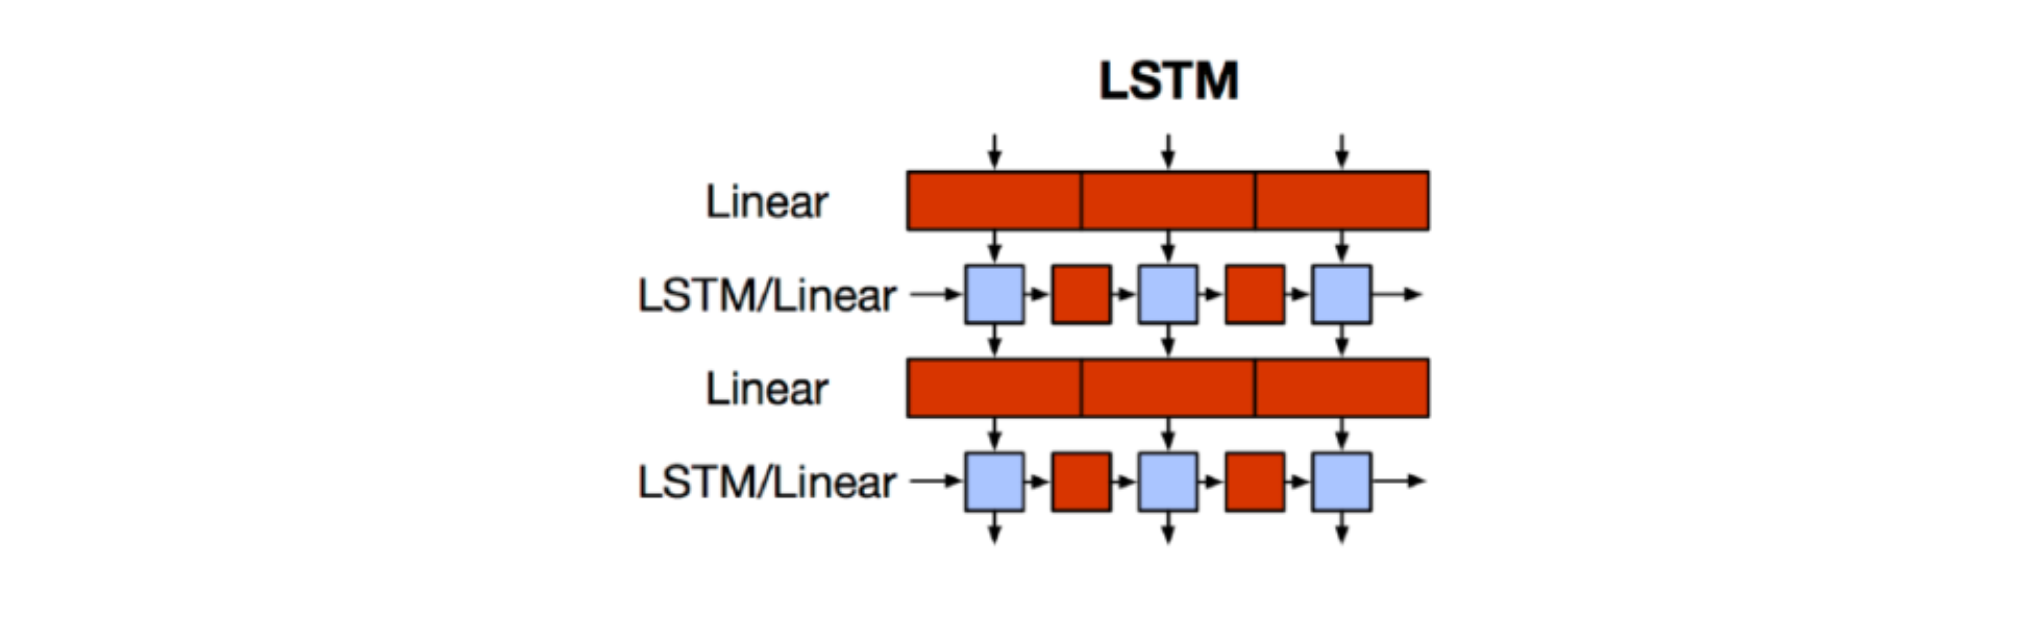
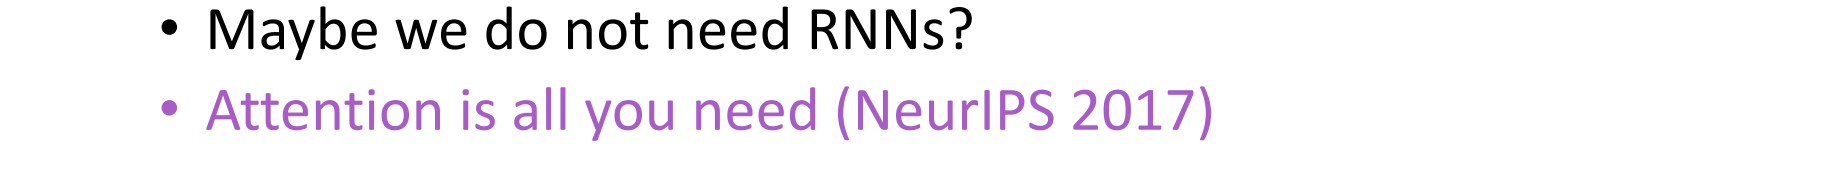

transformer整体架构：
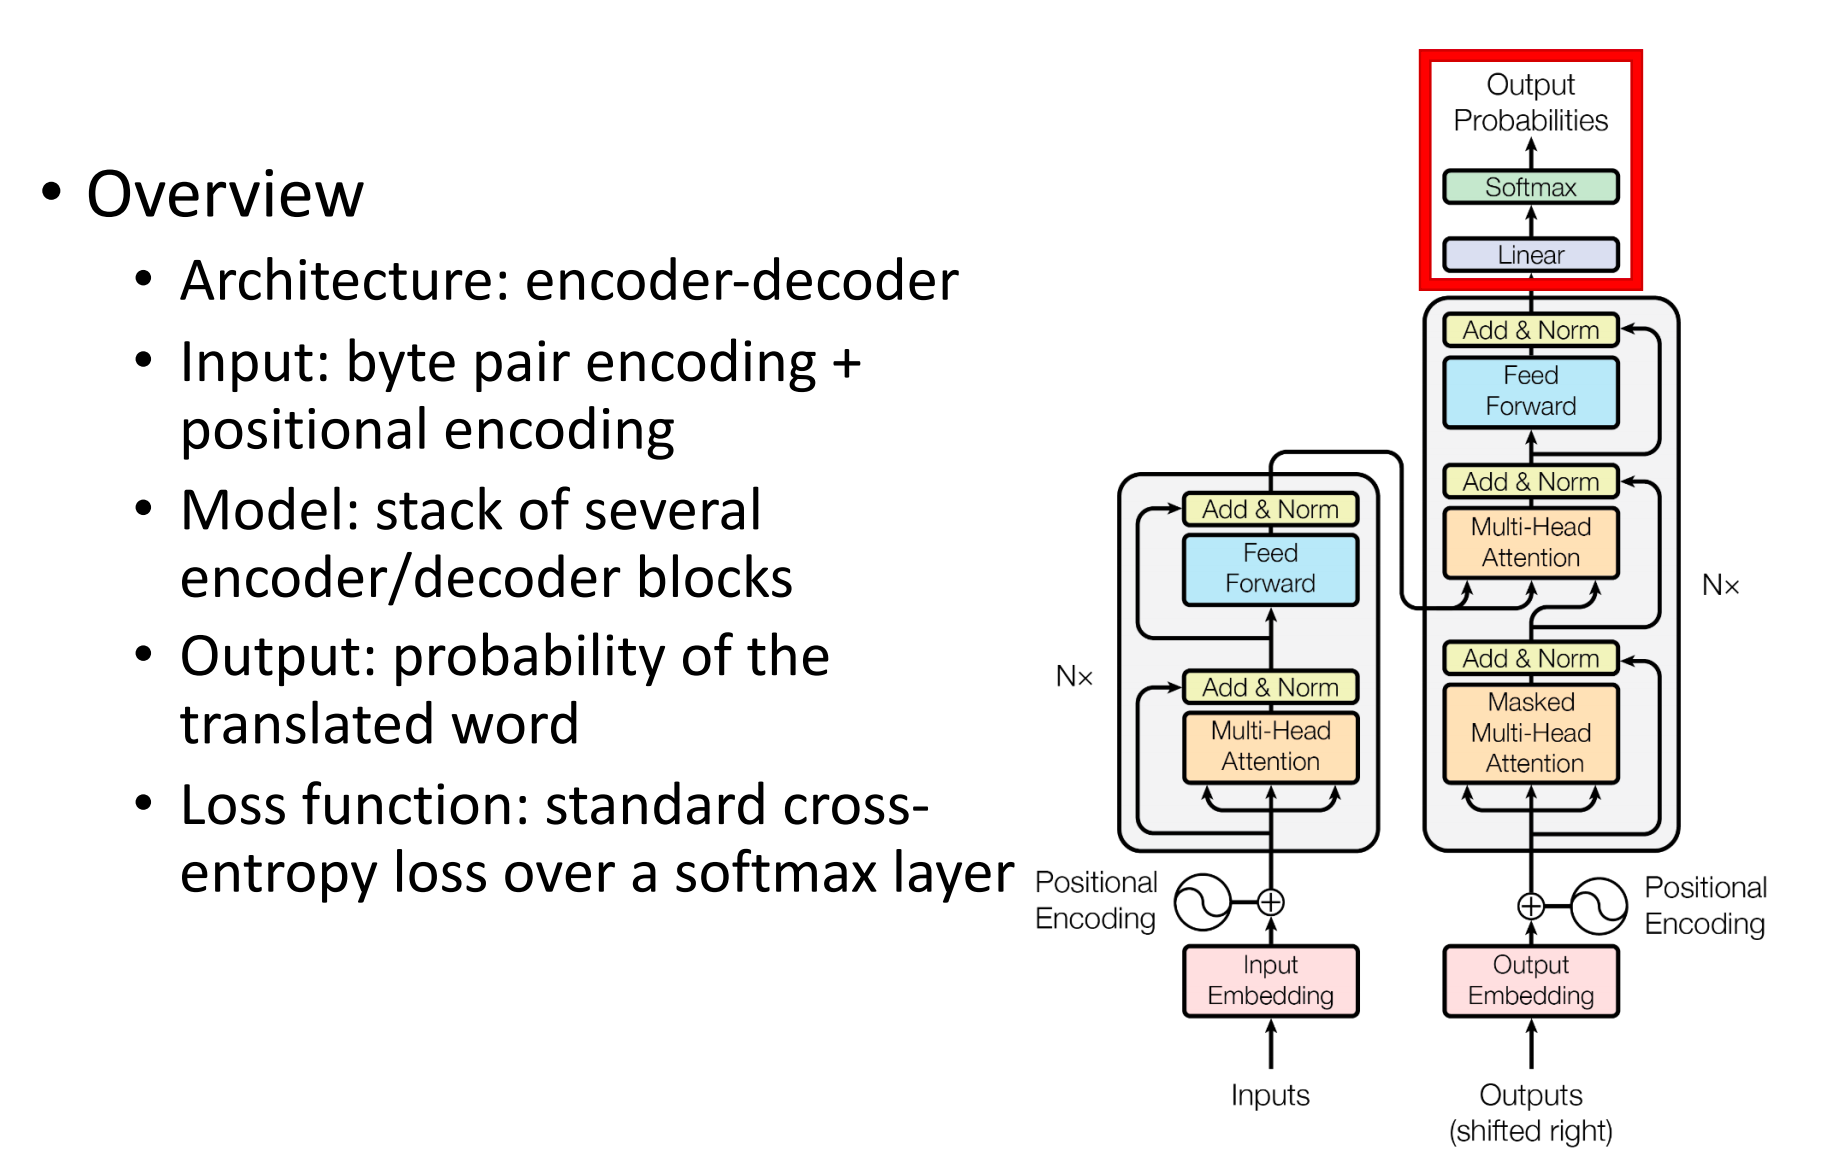

- 输出层（下方）：

需要将一个正常的文本序列切分成一个个小的单元（token），然后经过embedding层（嵌入层）化为向量表示。这里不同于RNN的地方有两点：

采用byte pair encoding（BPE）的方式对文本进行切分；
同时会在每个位置加上token的一个位置向量（positional encoding）。
- 主体（上方）：

是由多个encoder（左上）或decoer层（右上）堆叠而成的，不同层之间的结构相同，只是参数不同。transformer采用这种堆叠的方式来得到一个更深、表达能力更强的模型。

- 输出层（最上方）：

和之前RNN的输出层基本一致，也是由一个线性层和softmax层组成，用于输出词表上的概率分布。（训练过程中我们是通过计算在词表这样一个维度计算交叉熵来计算loss进而更新模型的一个参数）。


# 2. 输入编码（BPE、PE）

## Byte Pair Encoding (BPE)
在RNN中，我们一般以空格作为分隔符的方式进行简单的单词划分，但是这样子的缺点就是

词表维度过高，也即词表中词的数量过多；
另一个就是无法捕捉到单词之间的联系（例如同一个单词的单数和复数会对应不一样的ID（embedding）。


**byte pair encoding(BPE)**:

- 首先将语料库中的单词切分为一个个字母；
- 然后统计预料库中每一个Bigram（相邻2个）出现的次数；
- 接着把Bigram出现频率最高的词抽象为一个全新的词N加入词表，同时从原词表中剔除只在N中出现的词；
- 不断重复上述2-3过程，直到词表数量达到一定规模，进而实现了将该语料库划分为一个个高质量的token。


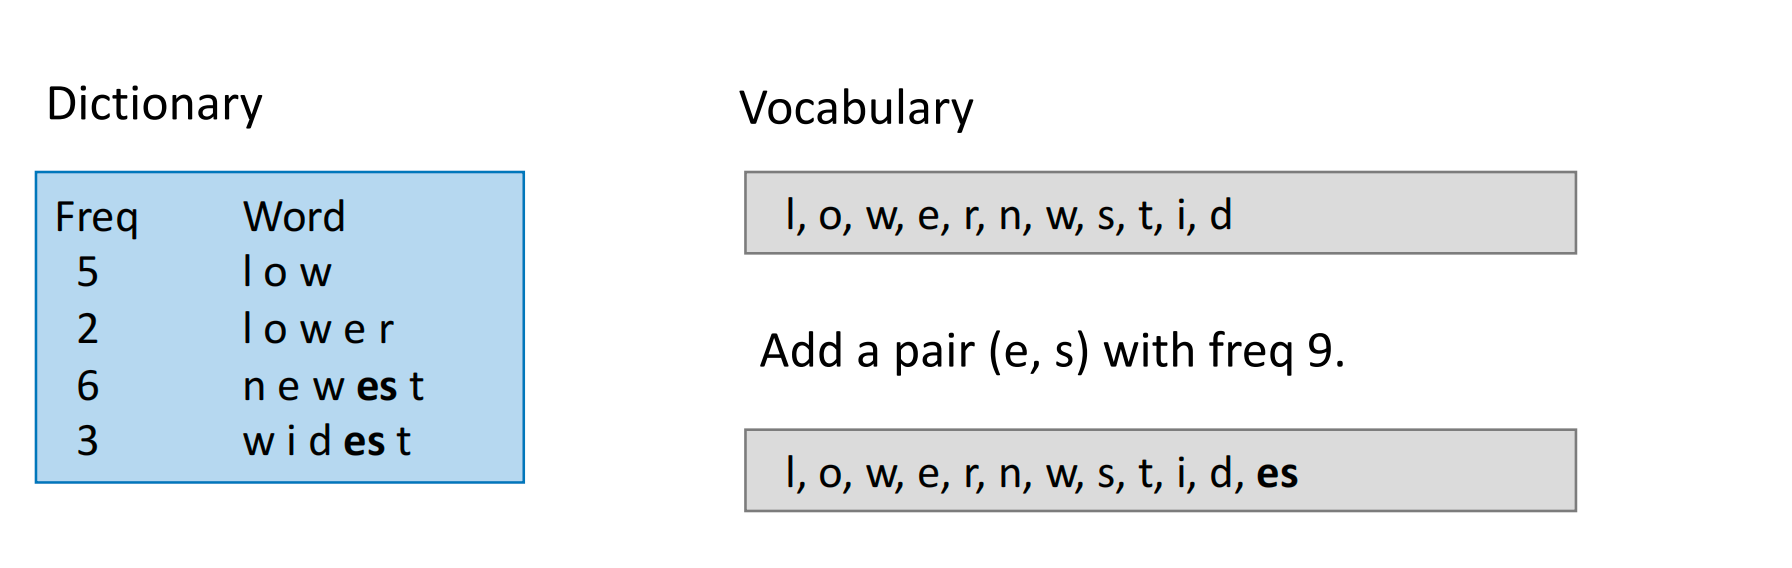
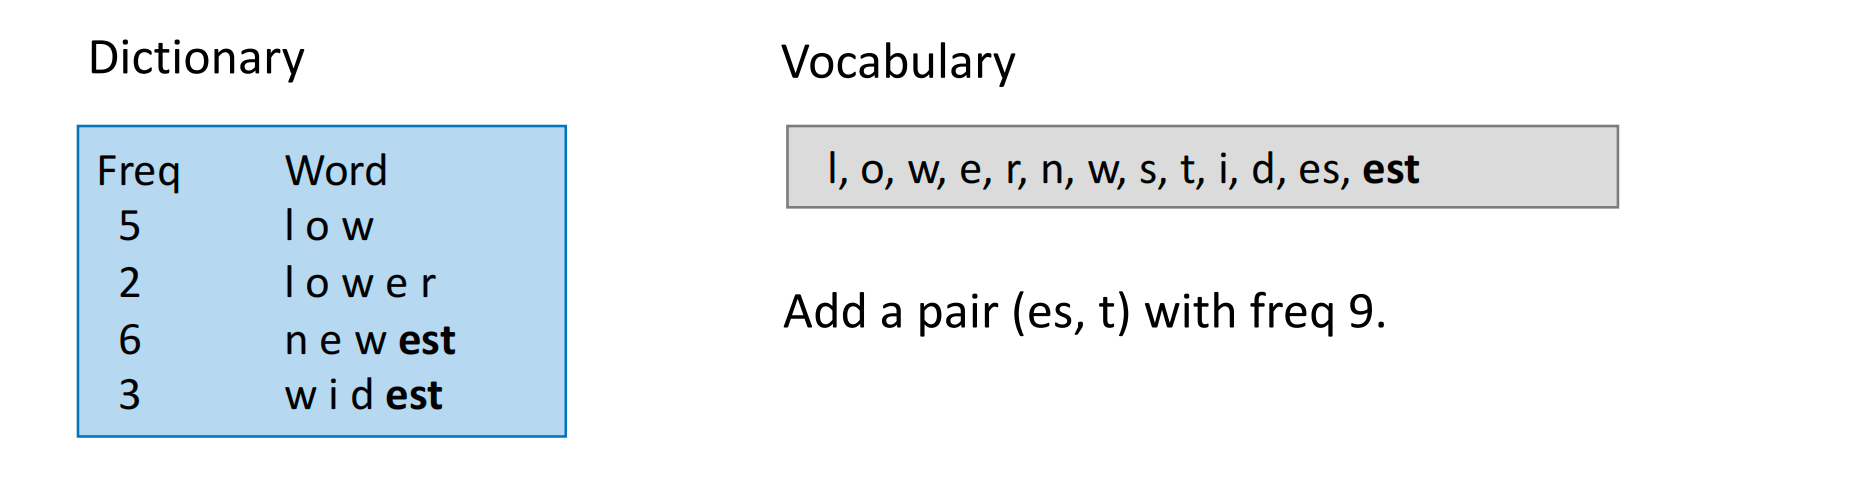

其他优点：  
BPE的出现也可以很好地解决在NLP中经常出现的OOV问题（out of vocabulary）（在输入文本中出现了一些在词表中没有出现过的词），这就导致模型无法理解这个新单词的含义，模型也无法找到这个对应的向量表示，这个时候往往会使用一个UNK的符号来代替。

比如对于单词“lowest"，如果在现有词表中没有这个单词的话，通过BPE我们可以将其分解为low和est，这样就实现了对新的单词的一个表示，同样通过这样一种方式可以让模型学习到这三者之间的关系，这样的关系也可以泛化到像其他的单词中，比如smart和smartest。


## 位置编码Positional Encoding（PE）

- Transformer 的局限性：Transformer 模块本身对相同单词在不同位置不敏感，也就是说，它无法区分一个单词在句子中的位置信息，而位置信息对于理解句子语义往往很重要。
- 位置编码的作用：为了解决上述问题，需要添加位置编码，使得相同单词在不同位置具有不同的表示。这样模型就能捕捉到单词的位置信息，提升对句子结构和语义的理解能力。

实现方式： 
- 在原有的embedding（嵌入层）上加入一个位置向量，使得不同位置的单词具备不同的表示。

- 我们假设BPE后词表中每个词经过embedding之后的向量维度为d，那么其对应的位置编码也需要是一个维度为d的向量。

  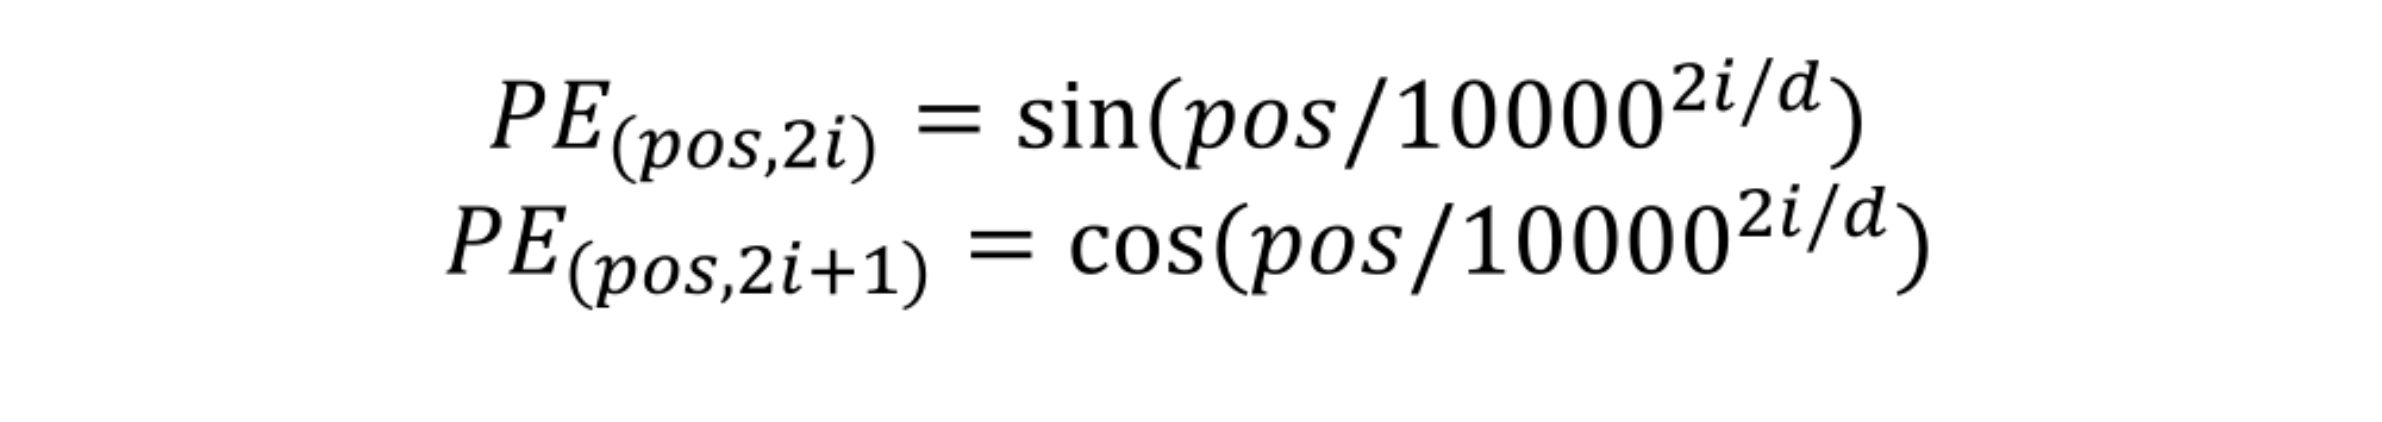

其中pos表示当前token在句子中的位置（它是一个从0到序列长度的一个数（注意这里的序列长度是指语句序列，而非词表的维度）） ，i则是从0-d/2的一个数（表示当前位置在embedding后的向量维度中的index）；

观察上式，可以发现embedding中的偶数位置是一个正弦函数，奇数位置是一个余弦函数。
949

<font color=red>最终：
Input = BPE + PE

# 3. Encoder Block

整体架构：
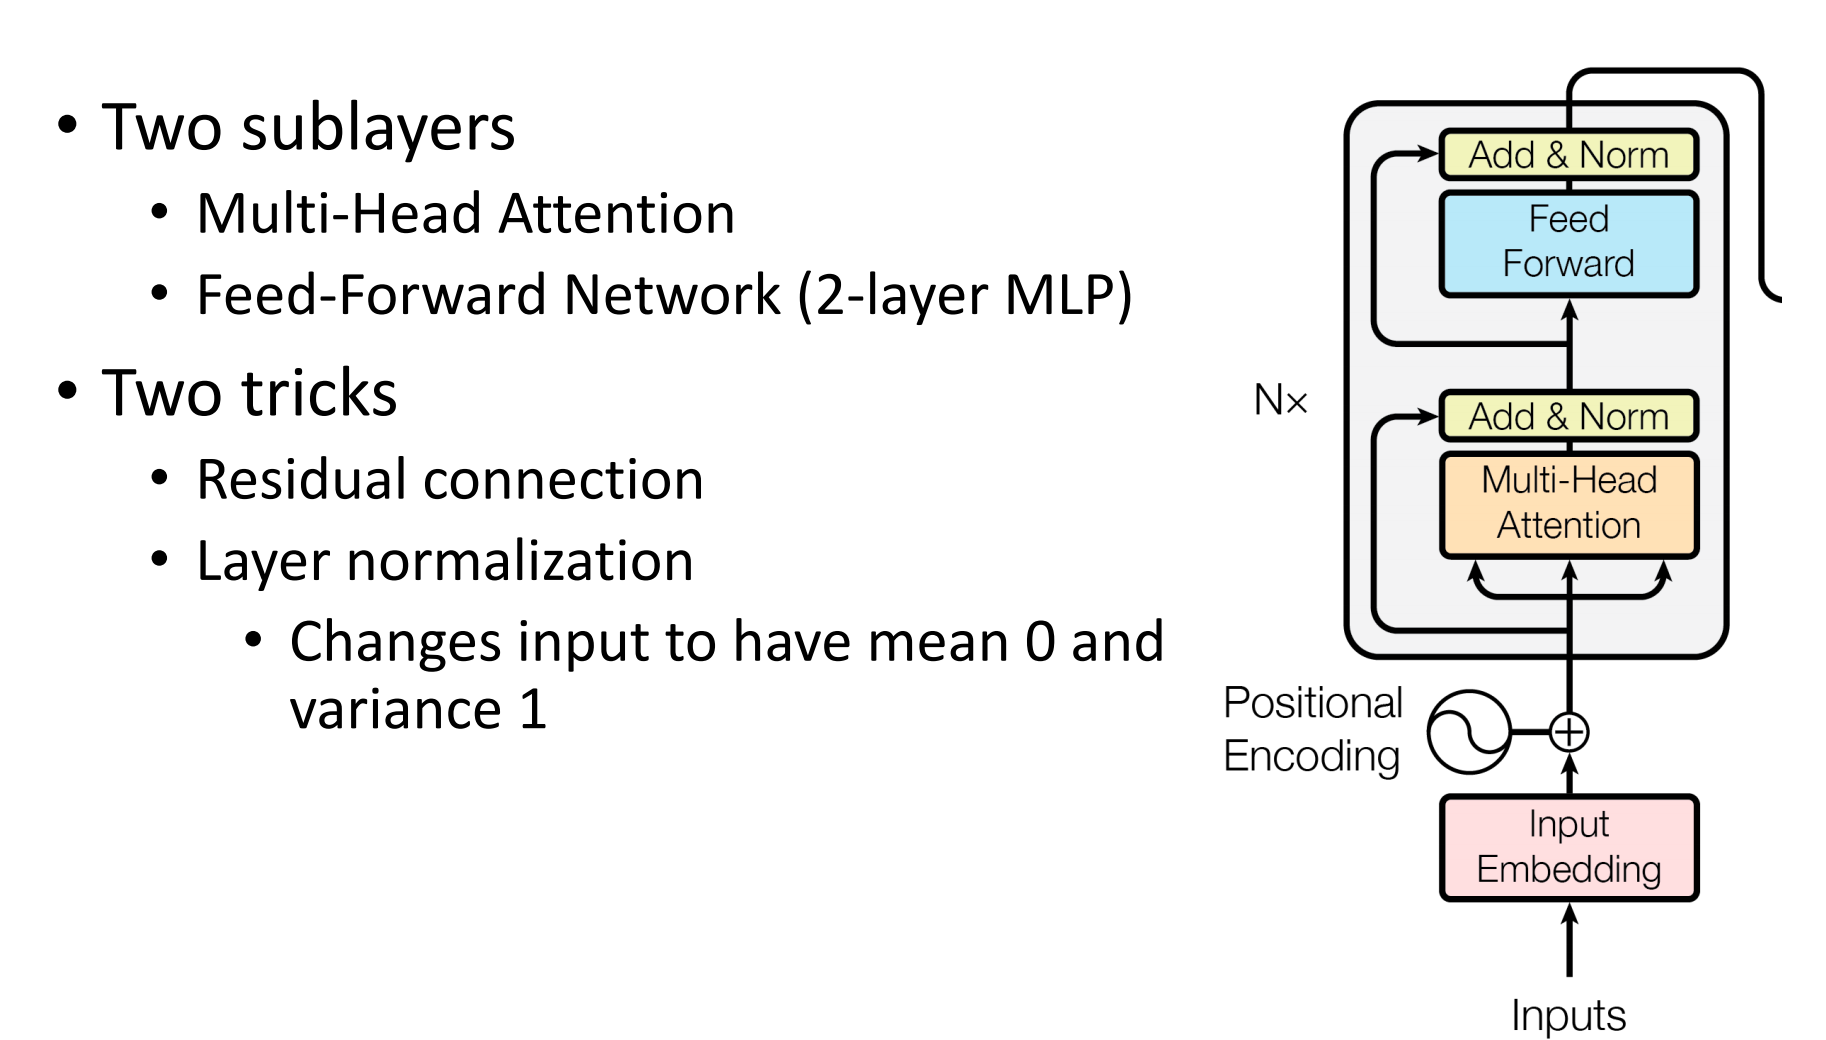
简单介绍一下
- 残差连接（ Residual connection）（对应导向黄色部分的Add）：借鉴于CV领域中著名的ResNet（本质就是将输入和输出直接相加，进而缓解模型过深后所造成的梯度消失问题）
- 正则化（Layer normalization）（对应黄色部分的Norm）：其实就是将输入的一个向量变为一个均值为0，方差为1（标准正态分布）的一个概率分布）（也是为了缓解梯度消失和梯度爆炸的问题）

## Transformer Block: Attention Layer


### 1 General Dot - Product Attention通用点积注意力机制

这部分内容介绍了Transformer中的通用点积注意力机制（General Dot - Product Attention），以下是详细讲解：

1. 输入（Inputs）
 - **查询、键值对**：该注意力机制接收一个查询向量 `q` 以及一组键值对 `(k, v)` 作为输入。
 - **向量维度**：查询向量 `q` 和键向量 `k` 的维度都是 $d_k$ 。维度一致是为了方便进行点积运算，以衡量查询和键之间的相似性。值向量 `v` 的维度为 $d_v$ ，其维度可以与查询和键不同，用于携带具体的特征信息 。

 2. 输出（Output）
 - **加权求和**：输出是值向量 `v` 的加权和。每个值向量的权重是通过查询向量 `q` 与对应键向量 `k` 的点积来计算的。点积结果越大，表示查询和键的相关性越高，那么对应的值在最终输出中所占的权重就越大。
 - **权重计算公式**：
    - 单个查询的情况：公式 $$A(q, K, V) = \sum_{i} \frac{e^{q \cdot k_i}}{\sum_{j} e^{q \cdot k_j}} v_i$$
   $q \cdot k_i$ 计算查询向量 `q` 与第 `i` 个键向量 `k_i` 的点积，$e^{q \cdot k_i}$ 对其进行指数化处理，$\sum_{j} e^{q \cdot k_j}$ 是归一化因子，确保所有权重之和为1。$\frac{e^{q \cdot k_i}}{\sum_{j} e^{q \cdot k_j}}$ 就是第 `i` 个值向量 `v_i` 的权重，最后对所有值向量按权重求和得到输出。
    - 多个查询的情况：当有多个查询时，将它们堆叠成矩阵 `Q` ，此时计算方式变为 $A(Q, K, V) = softmax(QK^T)V$ 。其中，`QK^T` 计算查询矩阵 `Q` 和键矩阵 `K` 的转置的乘积，得到一个注意力分数矩阵，再通过softmax函数将其转换为权重矩阵，最后与值矩阵 `V` 相乘，得到所有查询对应的加权和结果。




我们可以发现，不同q的计算之间是互不干扰的，也即可以以并行的方式计算。
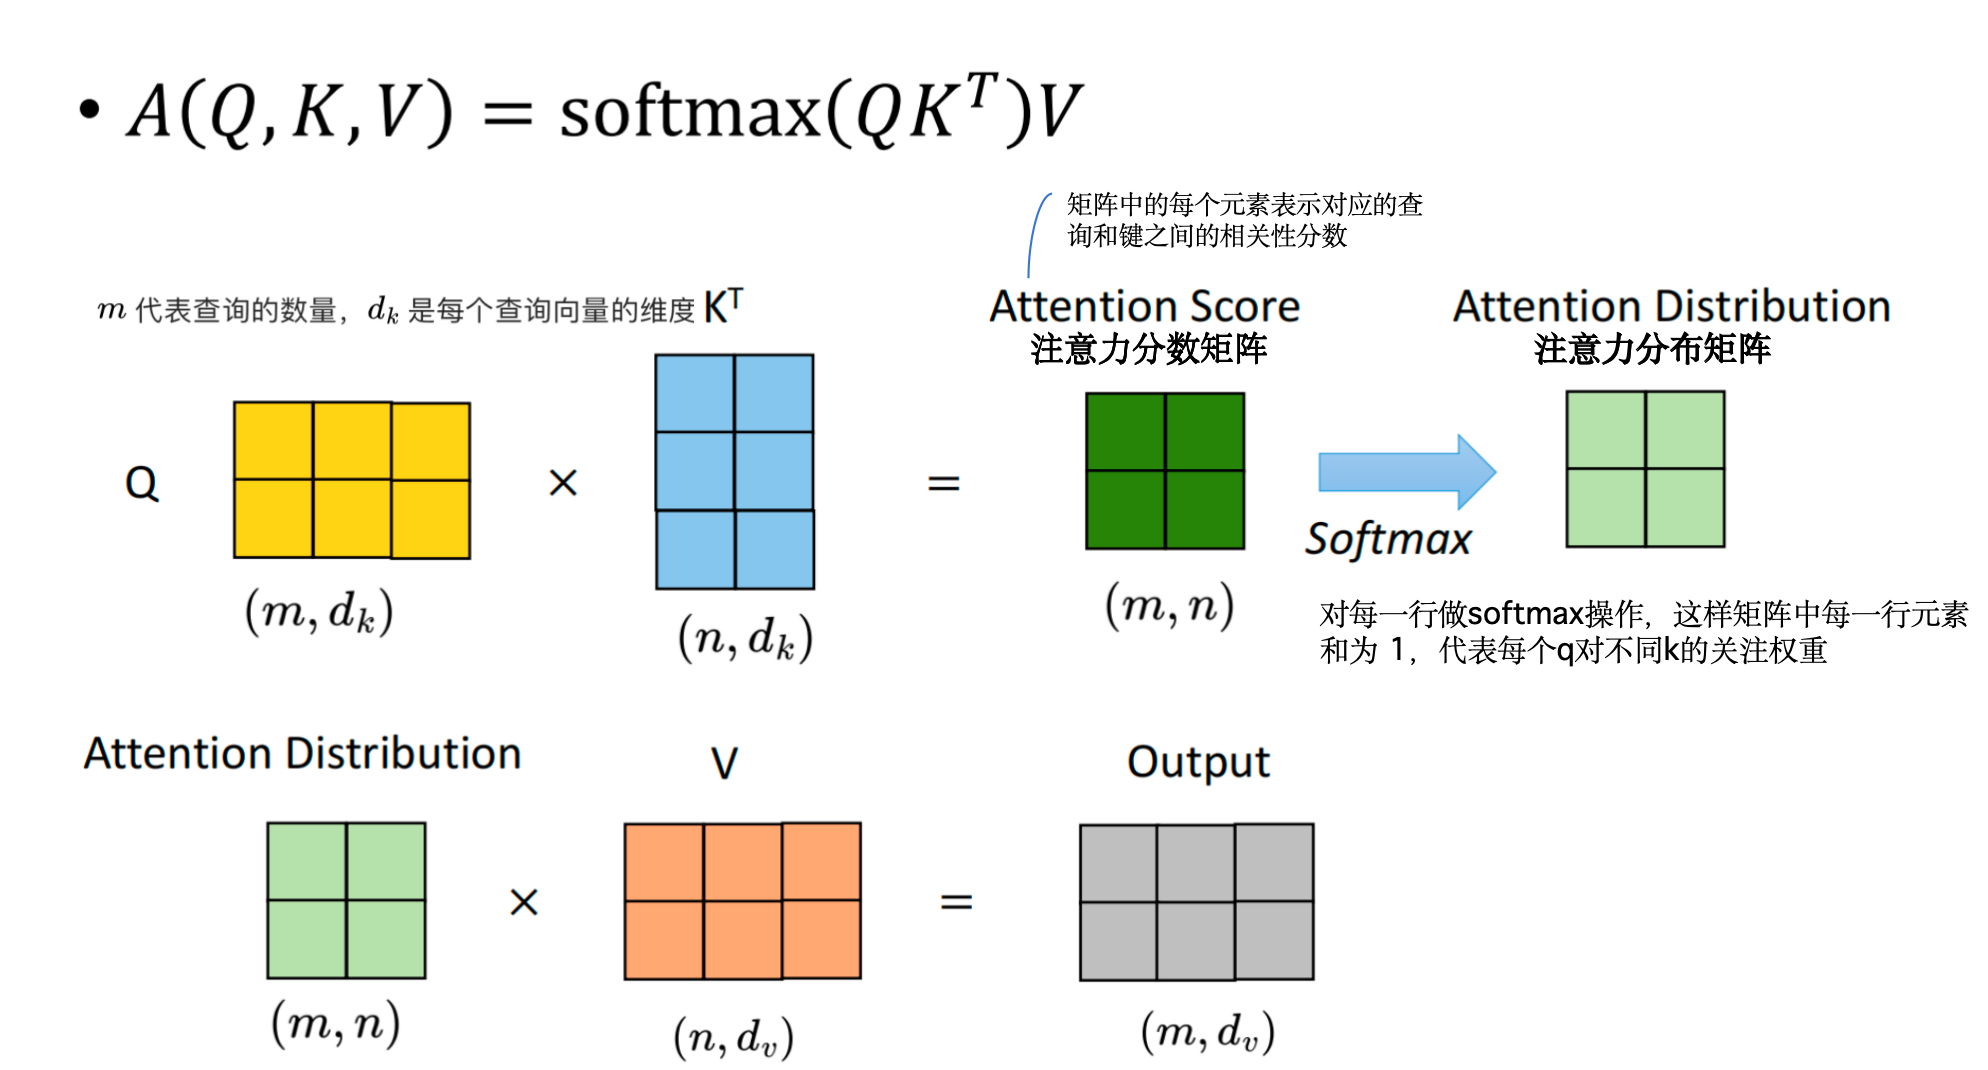

### 2 Scaled Dot-Product Attention 缩放点积注意力机制

在缩放点积注意力机制（Scaled Dot - Product Attention）中，随着查询向量和键向量维度$d_k$的增大，$q^T \cdot k$的方差会增加，原因如下：
- **高维空间中向量点积的特性**：在高维空间中，向量的点积结果会受到更多维度上元素的影响。当$d_k$增大时，点积运算涉及到更多的元素相乘和相加，这使得点积结果的分布范围更广，从而导致方差增大。

方差变化对softmax函数的影响主要体现在以下几个方面：
- **softmax输出的峰值变化**：当$q^T \cdot k$的方差增大时，点积结果中较大的值与较小的值之间的差距会更加显著。经过指数运算$e^{x}$后，这种差距会被进一步放大，使得softmax函数的输出变得非常“尖锐”（very peaked），即大部分概率质量集中在少数几个元素上，其他元素对应的概率几乎为0。
- **梯度消失问题**：由于softmax函数输出变得尖锐，在反向传播计算梯度时，较小概率对应的元素的梯度会变得非常小。这会导致模型在训练过程中参数更新缓慢，使得模型难以收敛。具体来说，当$z_i$（softmax的输入）很大时，$softmax(z_i)$接近1，而$softmax(z_k)$（$k \neq i$）接近0，根据softmax的梯度公式$\frac{\partial \text{softmax}(z_i)}{\partial z_k} = \text{softmax}(z_i) \left( \delta_{ik} - \text{softmax}(z_k) \right)$，此时梯度大约为0，这就是梯度消失问题。
- **模型训练的不稳定性**：方差变化导致的softmax输出峰值变化和梯度消失问题，会使得模型在训练过程中变得不稳定。模型可能会陷入局部最优解，或者在训练过程中出现振荡，难以收敛到一个较好的结果。

为了避免这些问题，缩放点积注意力机制对$QK^T$的结果除以$\sqrt{d_k}$，以减小方差的影响，使softmax函数的输入值范围更加合理，避免输出过于尖锐，从而保证梯度的有效性，使模型能够更稳定地训练。
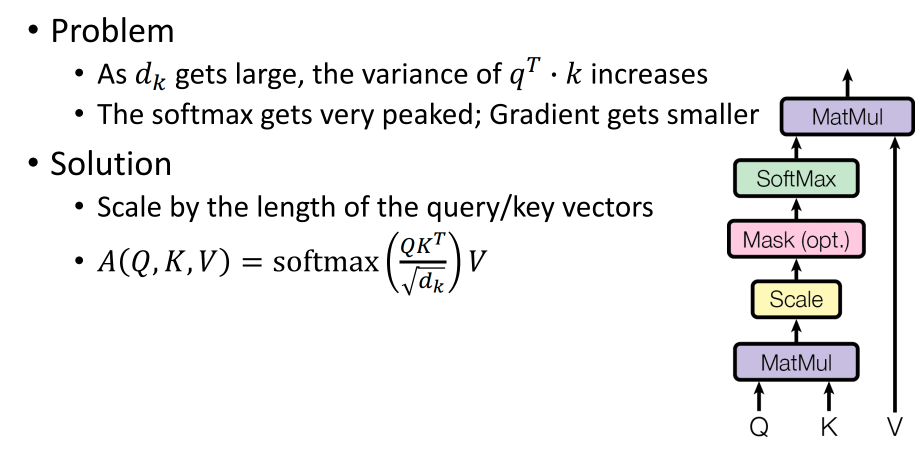

### 3 Self-attention 自注意力

在深度学习中，经常使用卷积神经网络（CNN）或循环神经网络（RNN）对序列进行编码。 想象一下，有了注意力机制之后，我们将词元序列输入注意力池化中， 以便同一组词元同时充当查询、键和值。 具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出。 由于查询、键和值来自同一组输入，因此被称为 自注意力（self-attention） 

因为前面我们讲到的Q，K，V分别用三个字母表示，但因为transformer中的attention使用的是一种自注意力机制，我们希望的是每个token能够自主地选择应该关注这句话中的哪些token并进行信息的整合，它们其实都等于文本的表示向量乘上一个变换矩阵得到的。

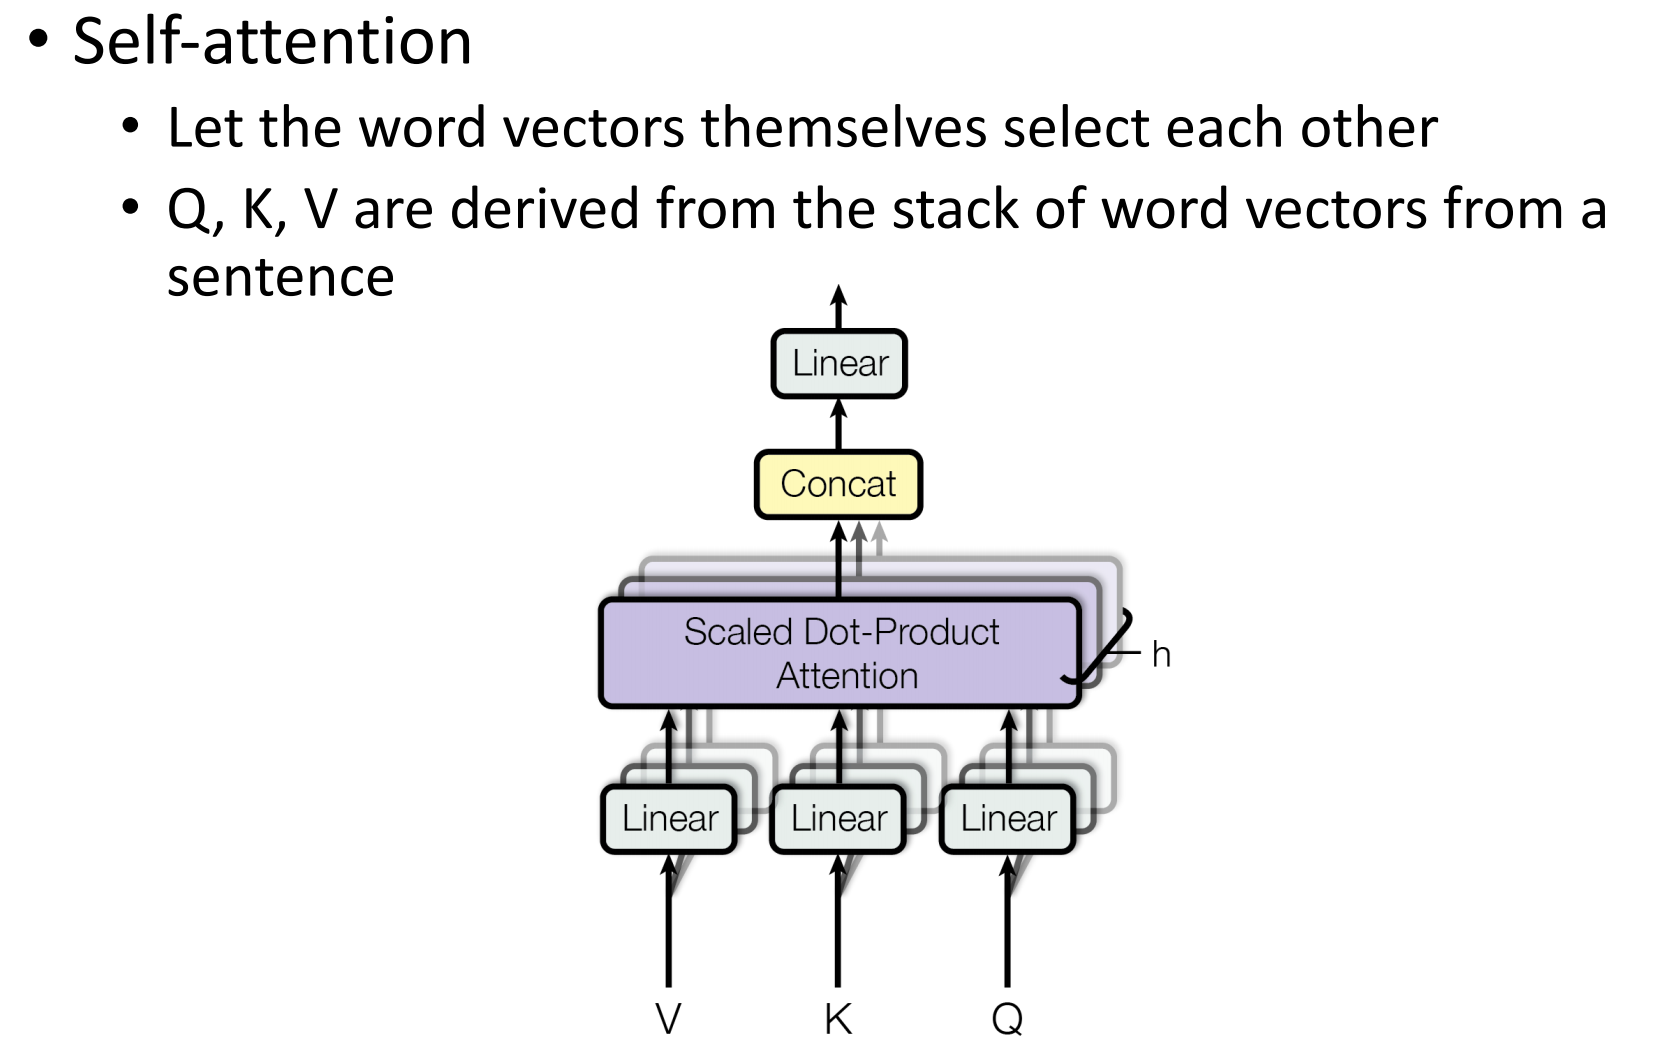

对于第一层来说：文本的表示向量就是输入层的词表向量和对应位置编码的一个求和。

对于非第一层：文本的表示向量就是前面一层的输出；



### 4  Multi-head Attention 多头注意力机制

多头注意力机制是在缩放点积注意力机制（Scaled Dot-Product Attention）基础上的扩展，目的是让模型在不同的表示子空间里学习到多种不同的注意力信息，从而捕捉更丰富的语义关系。
- 在单头的基础上，为了进一步增强模型的一个表示能力，进而采取多个单头（**结构相同参数不同**）组成多头注意力机制，注意，每个头的计算方式一致，只是每个头需要乘上一个不同的权重矩阵，也就是对应上图的Linear位置

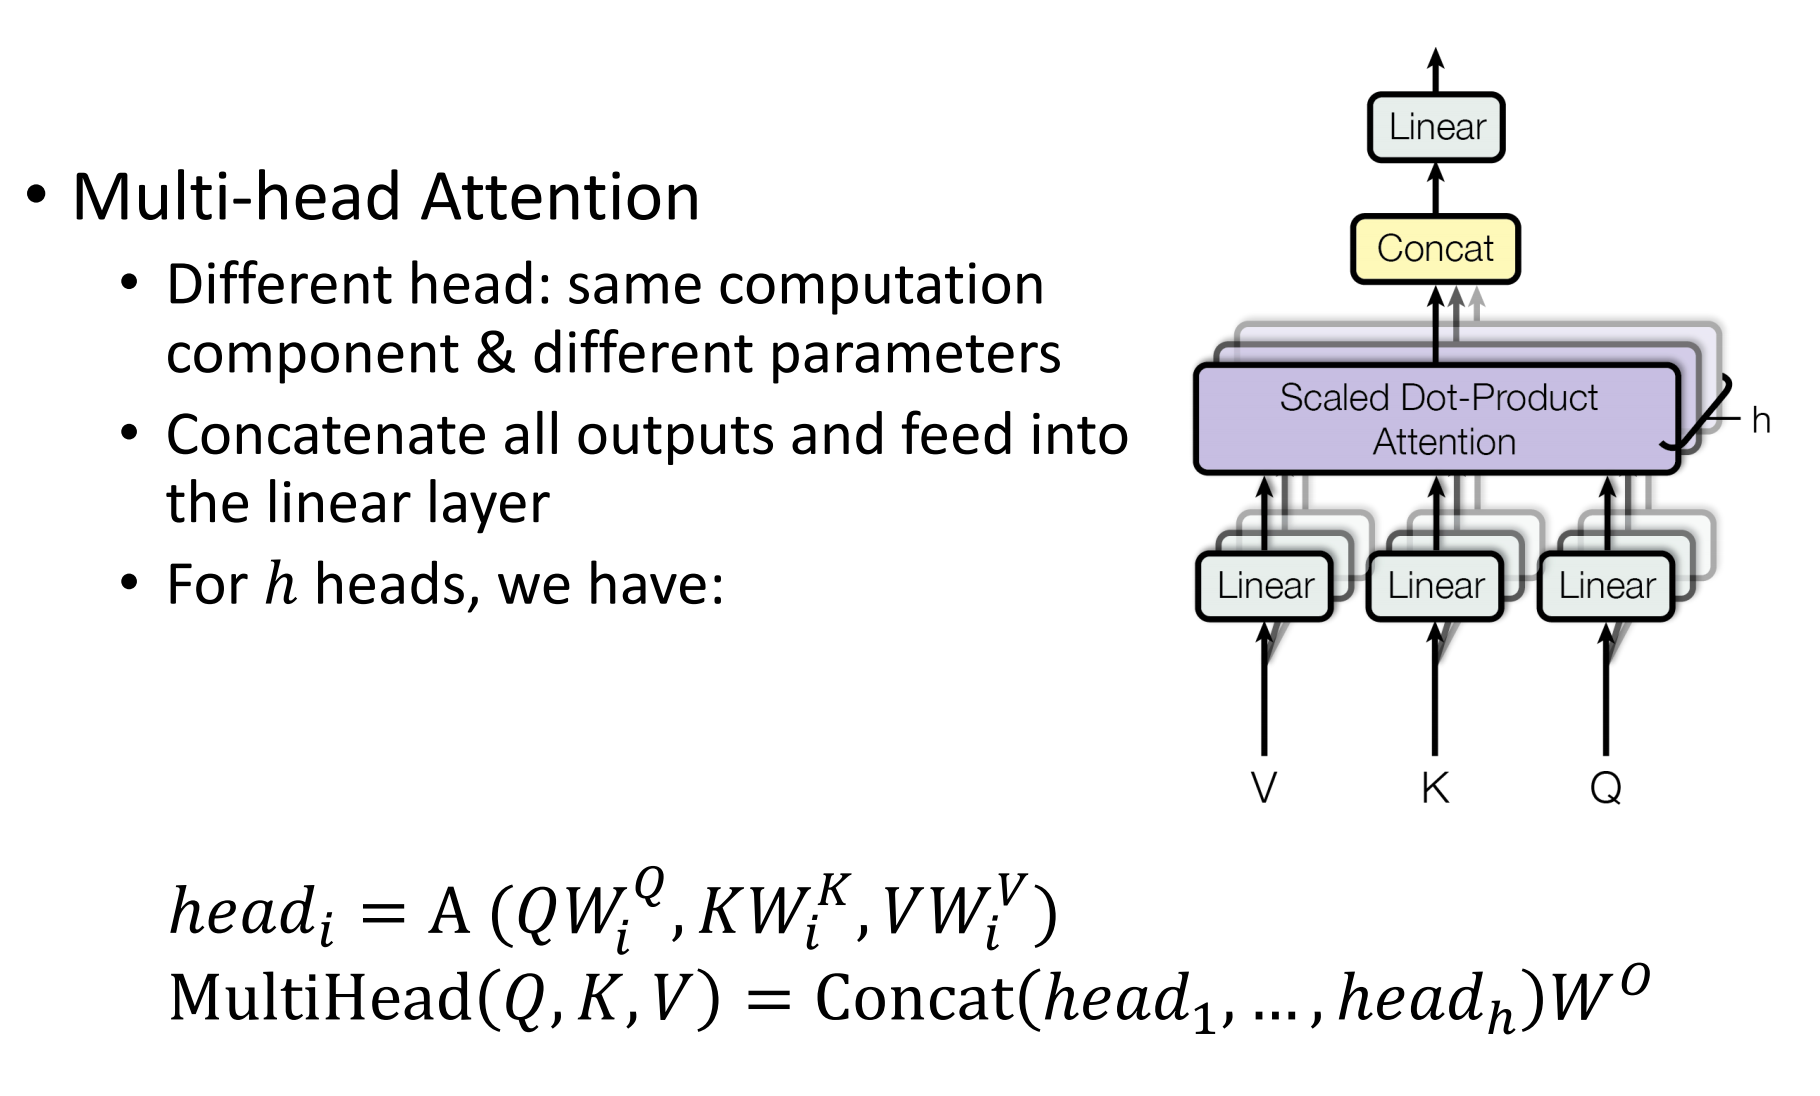
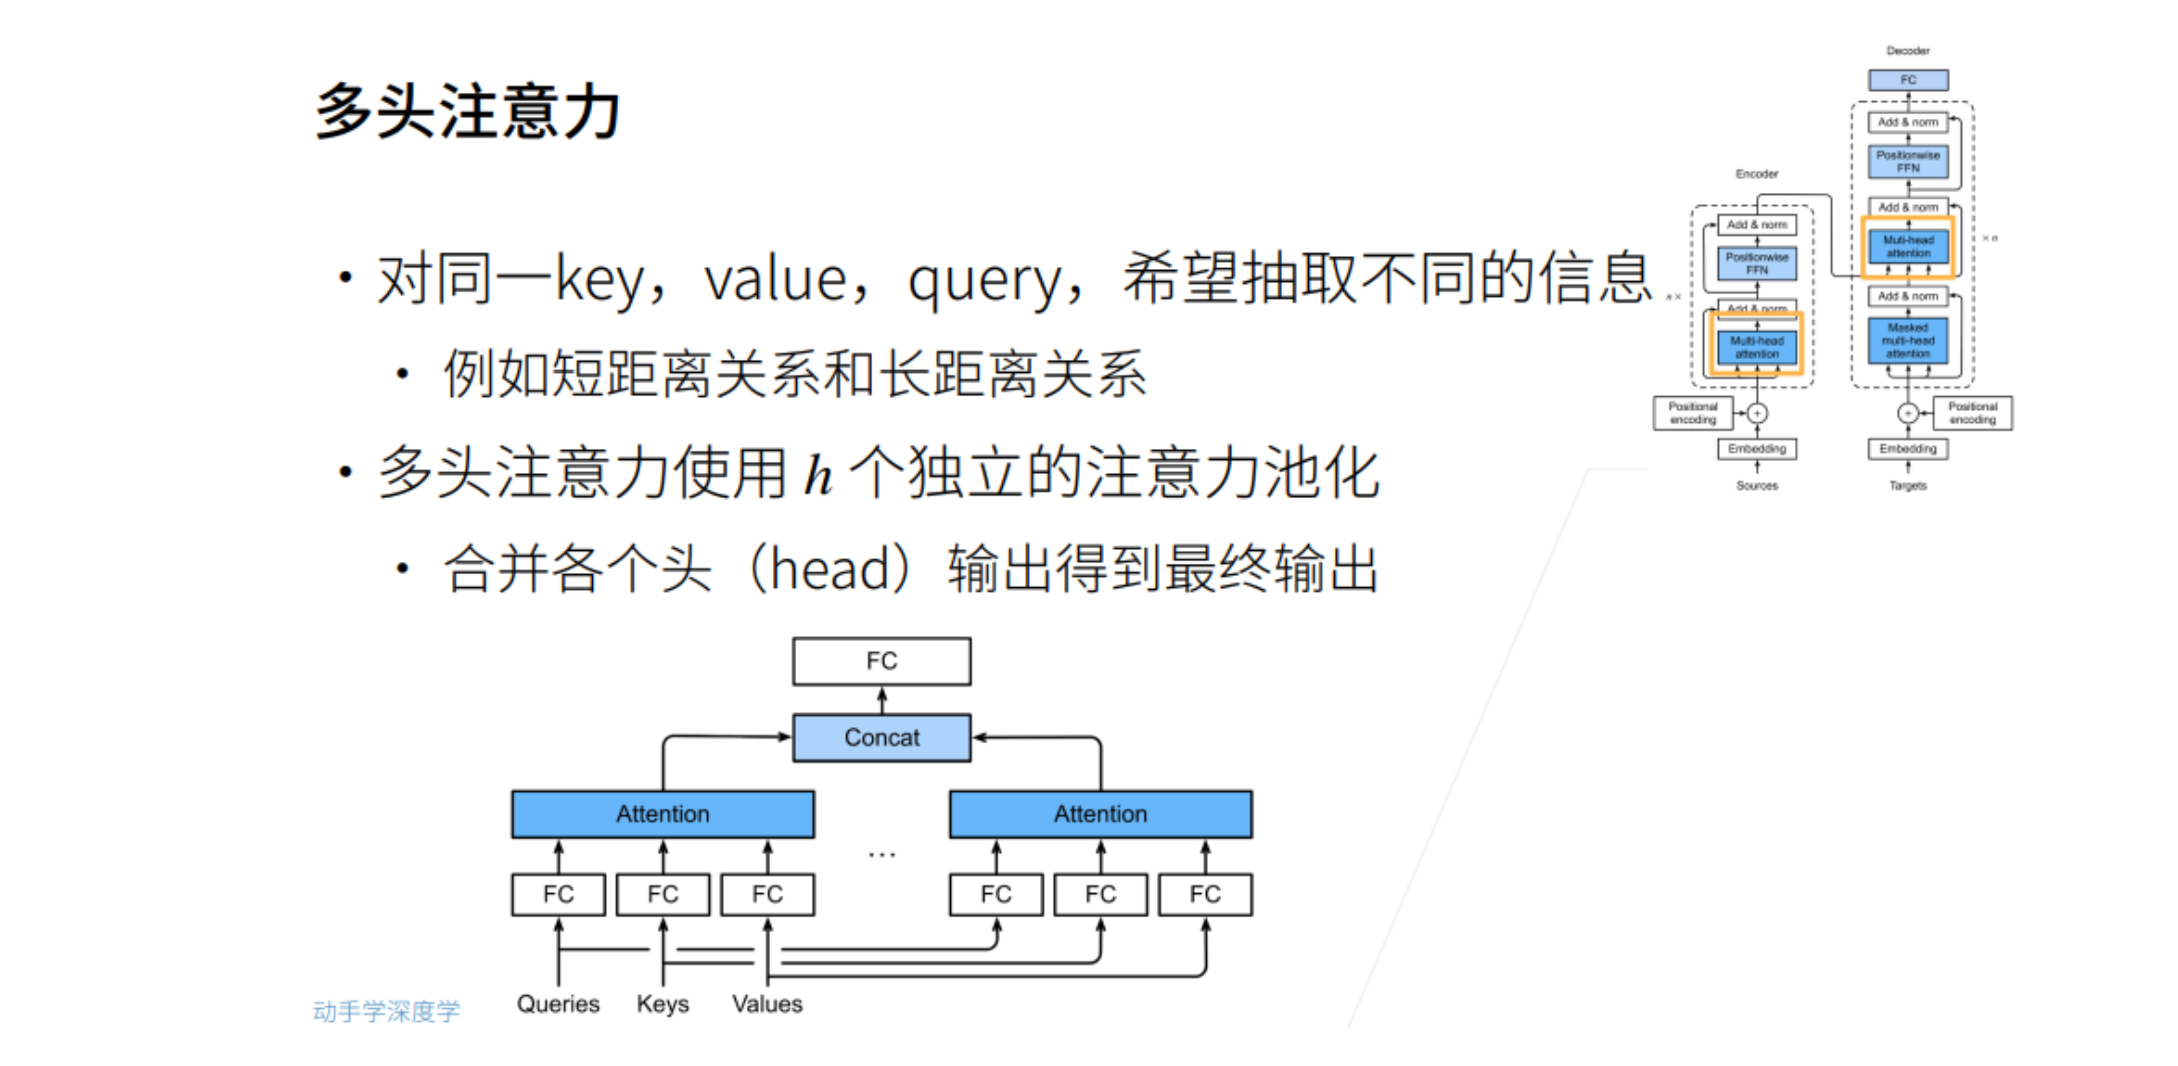

<font color=red> 数学表示：
- 每个头的可学习参数
  - **参数矩阵**：对于每个头 $i$ ，存在三个可学习的参数矩阵，分别是 $\mathbf{W}_i^{(q)} \in \mathbb{R}^{p_q \times d_q}$ 、$\mathbf{W}_i^{(k)} \in \mathbb{R}^{p_k \times d_k}$ 和 $\mathbf{W}_i^{(v)} \in \mathbb{R}^{p_v \times d_v}$ 。这些参数矩阵的作用是对输入的查询、键和值向量进行线性变换。
  - **变换目的**：通过与这些参数矩阵相乘，将输入向量映射到不同的子空间，使得模型能够从多个不同的角度捕捉输入向量之间的关系。不同的头拥有不同的参数矩阵，这使得每个头可以学习到不同的注意力表示。
- 每个头的输出
  - **计算方式**：头 $i$ 的输出 $\mathbf{h}_i$ 是通过一个函数 $f$ 对变换后的查询、键和值向量进行计算得到的，即 $\mathbf{h}_i = f(\mathbf{W}_i^{(q)} \mathbf{q}, \mathbf{W}_i^{(k)} \mathbf{k}, \mathbf{W}_i^{(v)} \mathbf{v})$ 。这里的函数 $f$ 通常是缩放点积注意力（Scaled Dot - Product Attention）函数。
  - **输出维度**：$\mathbf{h}_i \in \mathbb{R}^{p_v}$ ，表示每个头的输出是一个 $p_v$ 维的向量。

- 多头注意力机制的输出相关参数和计算
  - **输出参数矩阵**：存在一个输出的可学习参数矩阵 $\mathbf{W}_o \in \mathbb{R}^{p_o \times hp_v}$ ，其中 $h$ 是头的数量。这个参数矩阵用于对所有头的输出进行进一步的变换和整合。 
  - **输出计算**：将 $h$ 个头的输出 $\mathbf{h}_1, \mathbf{h}_2, \cdots, \mathbf{h}_h$ 按顺序堆叠起来，然后与参数矩阵 $\mathbf{W}_o$ 相乘，得到多头注意力机制的最终输出，结果属于 $\mathbb{R}^{p_o}$ 维度的向量 。
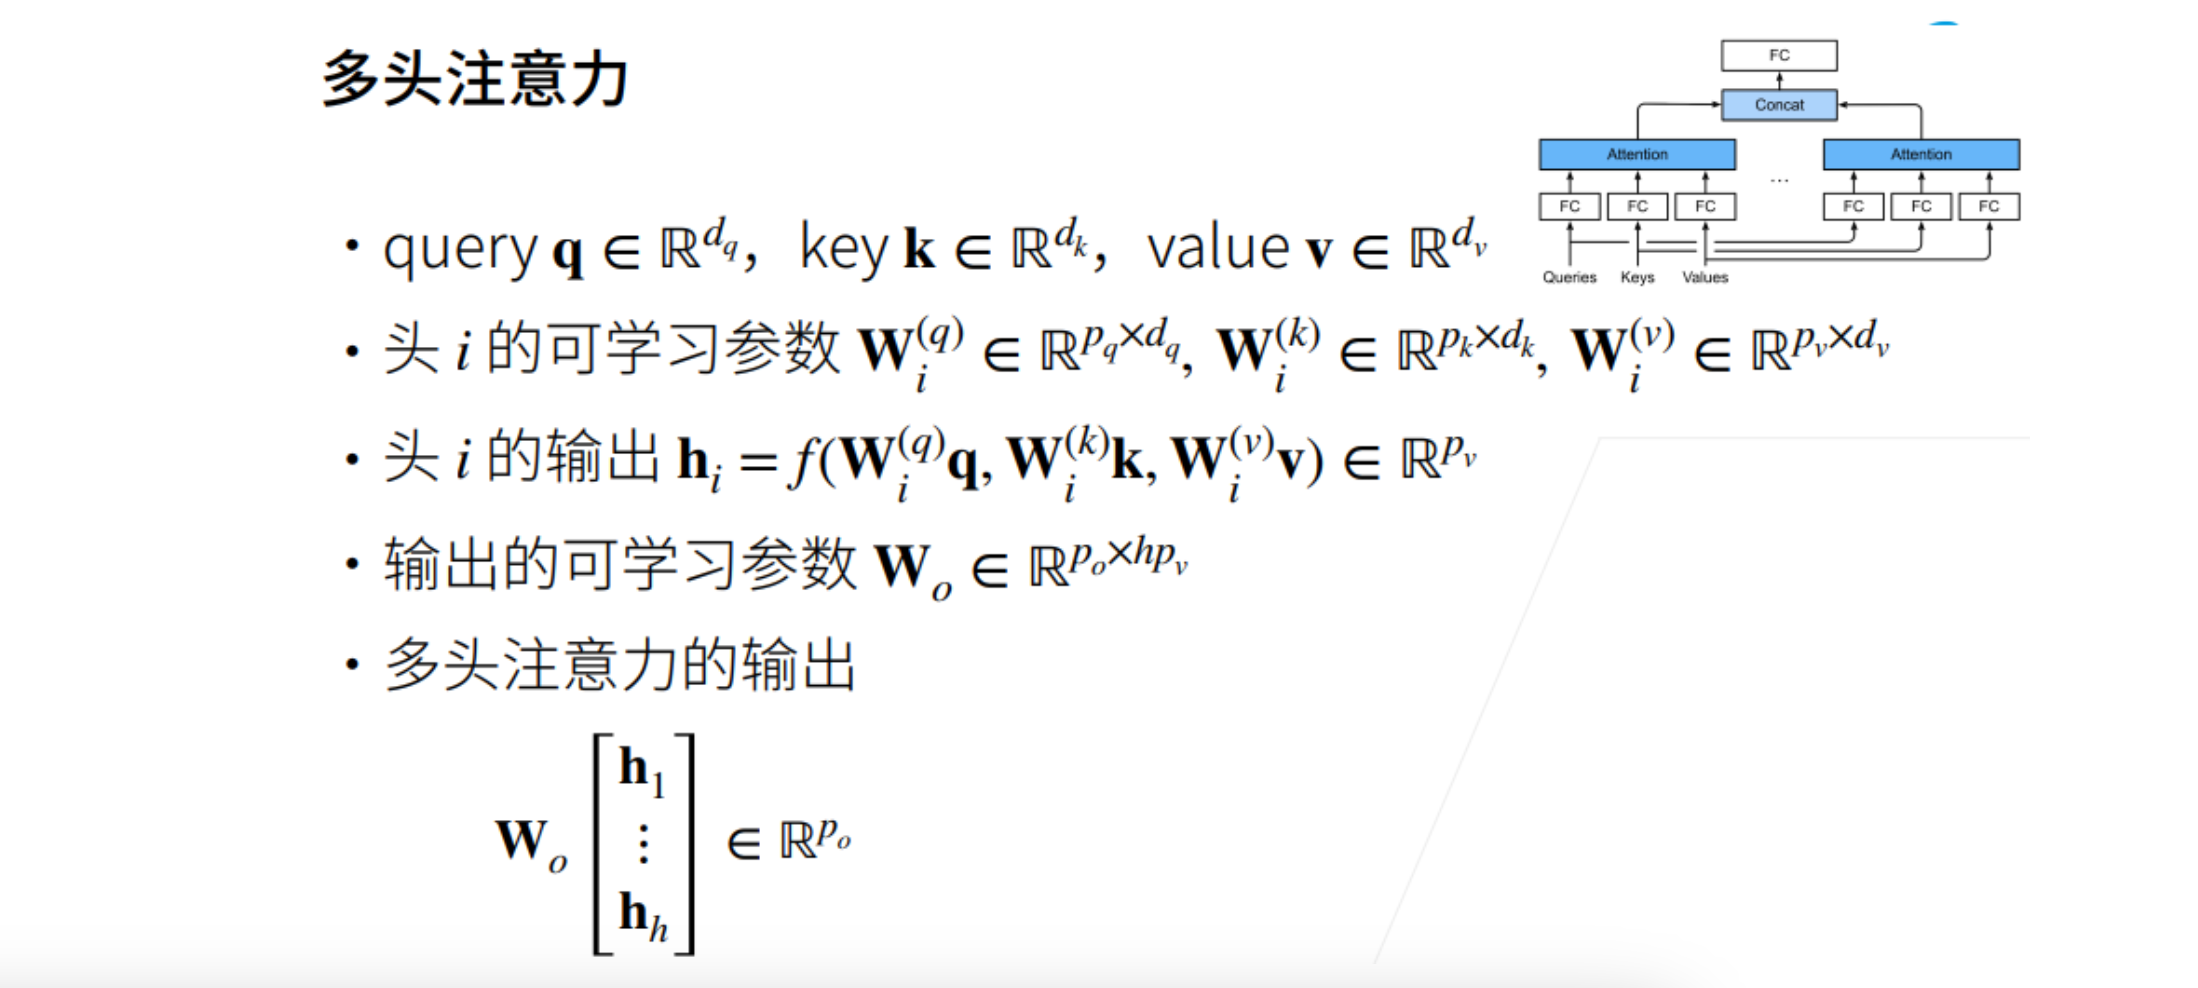



总体再回顾一下：
- Encoder层是通过堆叠多个相同的Encoder模块来构建的（对应于图片中的N）。每个Encoder模块都包含了多头自注意力机制和前馈神经网络（FFN）层
- 第一个编码器块的输入通常是输入序列的嵌入表示。后续的编码器块则接收前一层编码器块的输出作为输入。

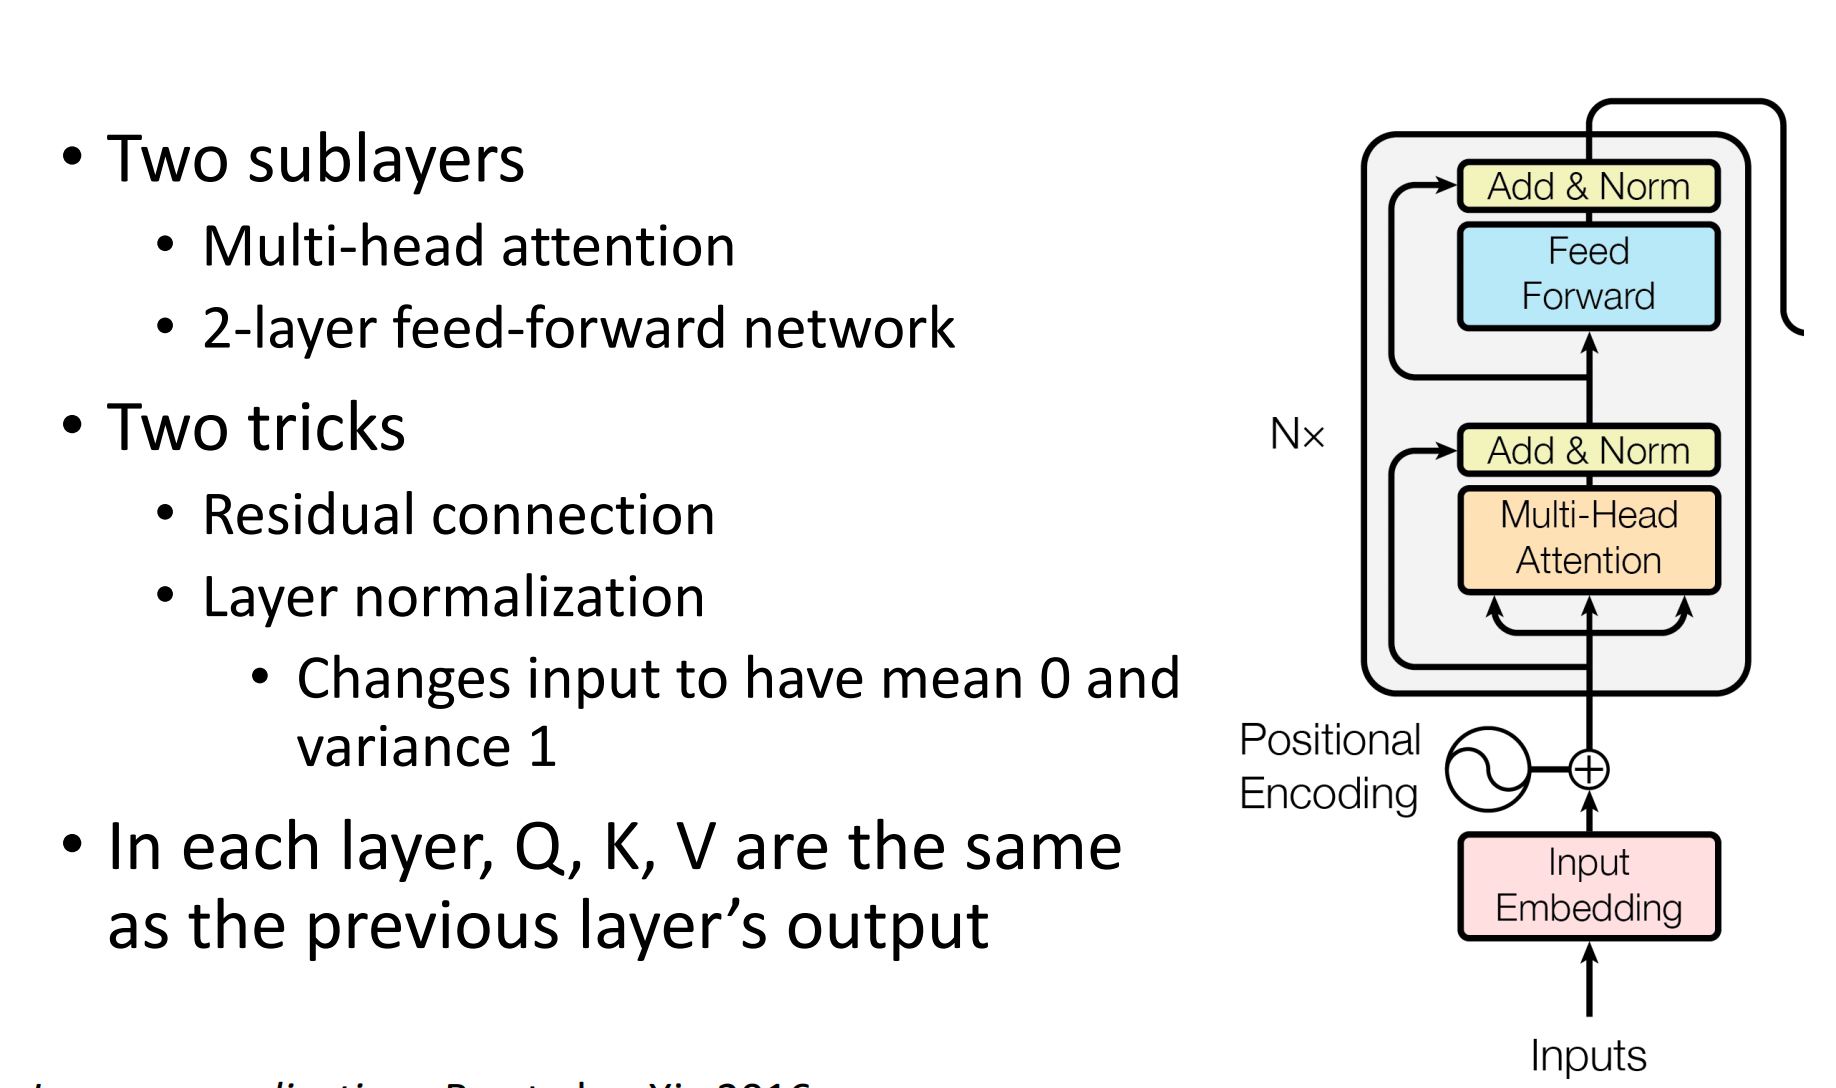

### Feed-Forward Network (2-layer MLP)前馈神经网络

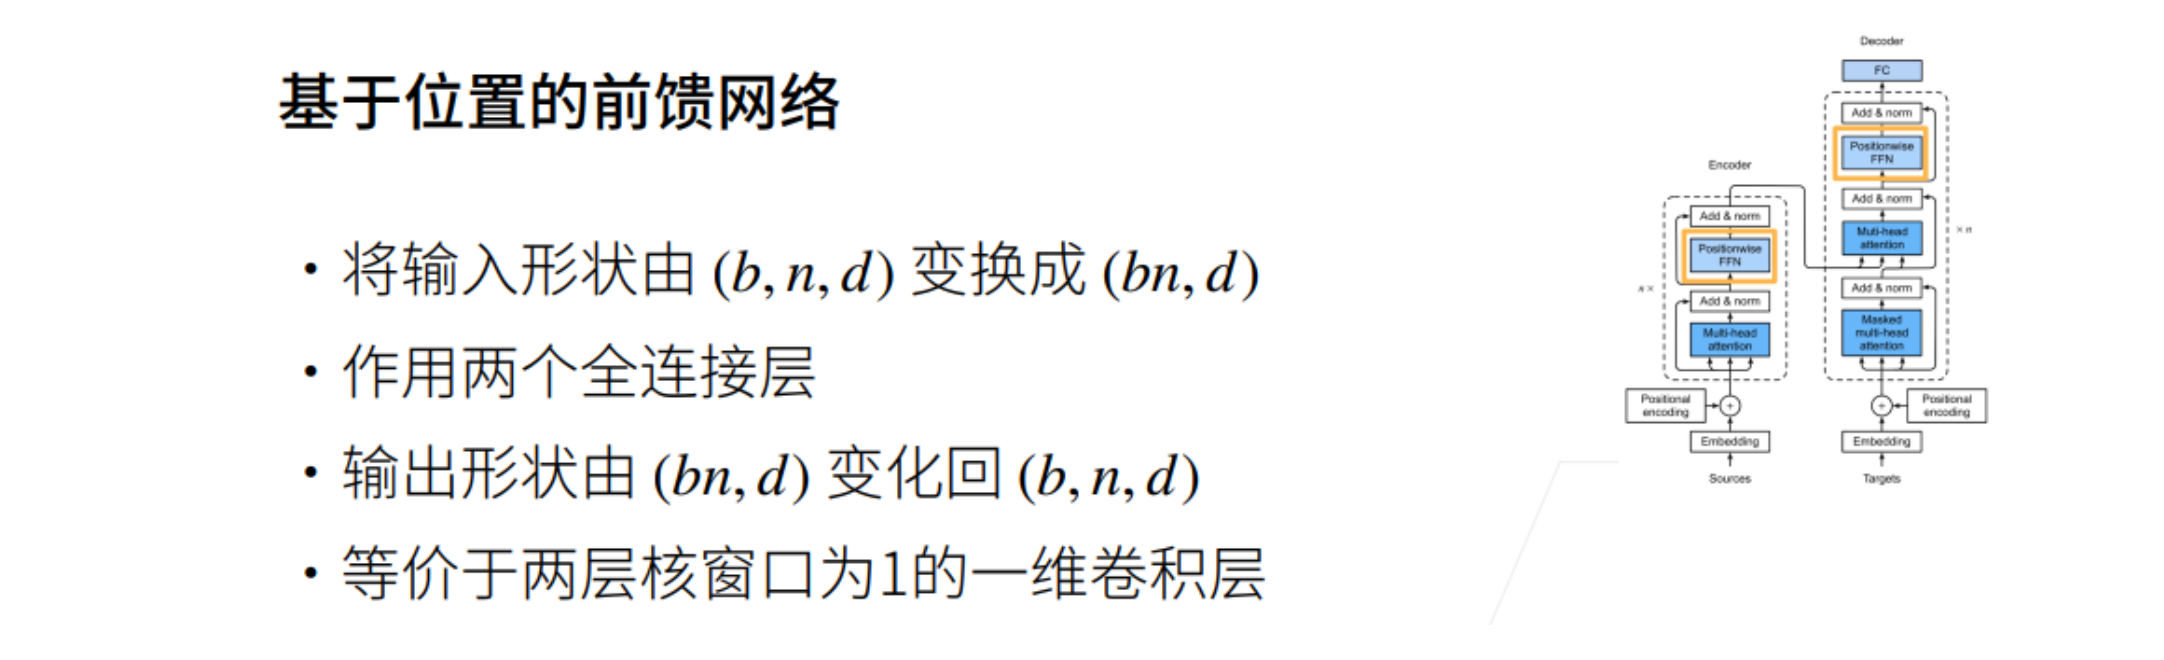
 - 输入形状为 $(b, n, d)$，其中 $b$ 代表批量大小（batch size），即一次处理样本的数量；$n$ 代表序列长度（sequence length），比如文本中单词的数量；$d$ 代表每个位置的特征维度（feature dimension）。为了便于后续全连接层处理，会将输入形状变换为 $(bn, d)$，也就是把批量维度和序列维度合并。

 - 该前馈网络包含两个全连接层（fully - connected layers）。全连接层会对输入的特征进行线性变换，并通过激活函数引入非线性，进一步提取和转换特征。 


 - 经过两个全连接层处理后，输出形状会从 $(bn, d)$ 再变换回 $(b, n, d)$，恢复成原始的批量和序列维度结构，以符合Transformer后续模块的输入要求。




### layer normalization层归一化

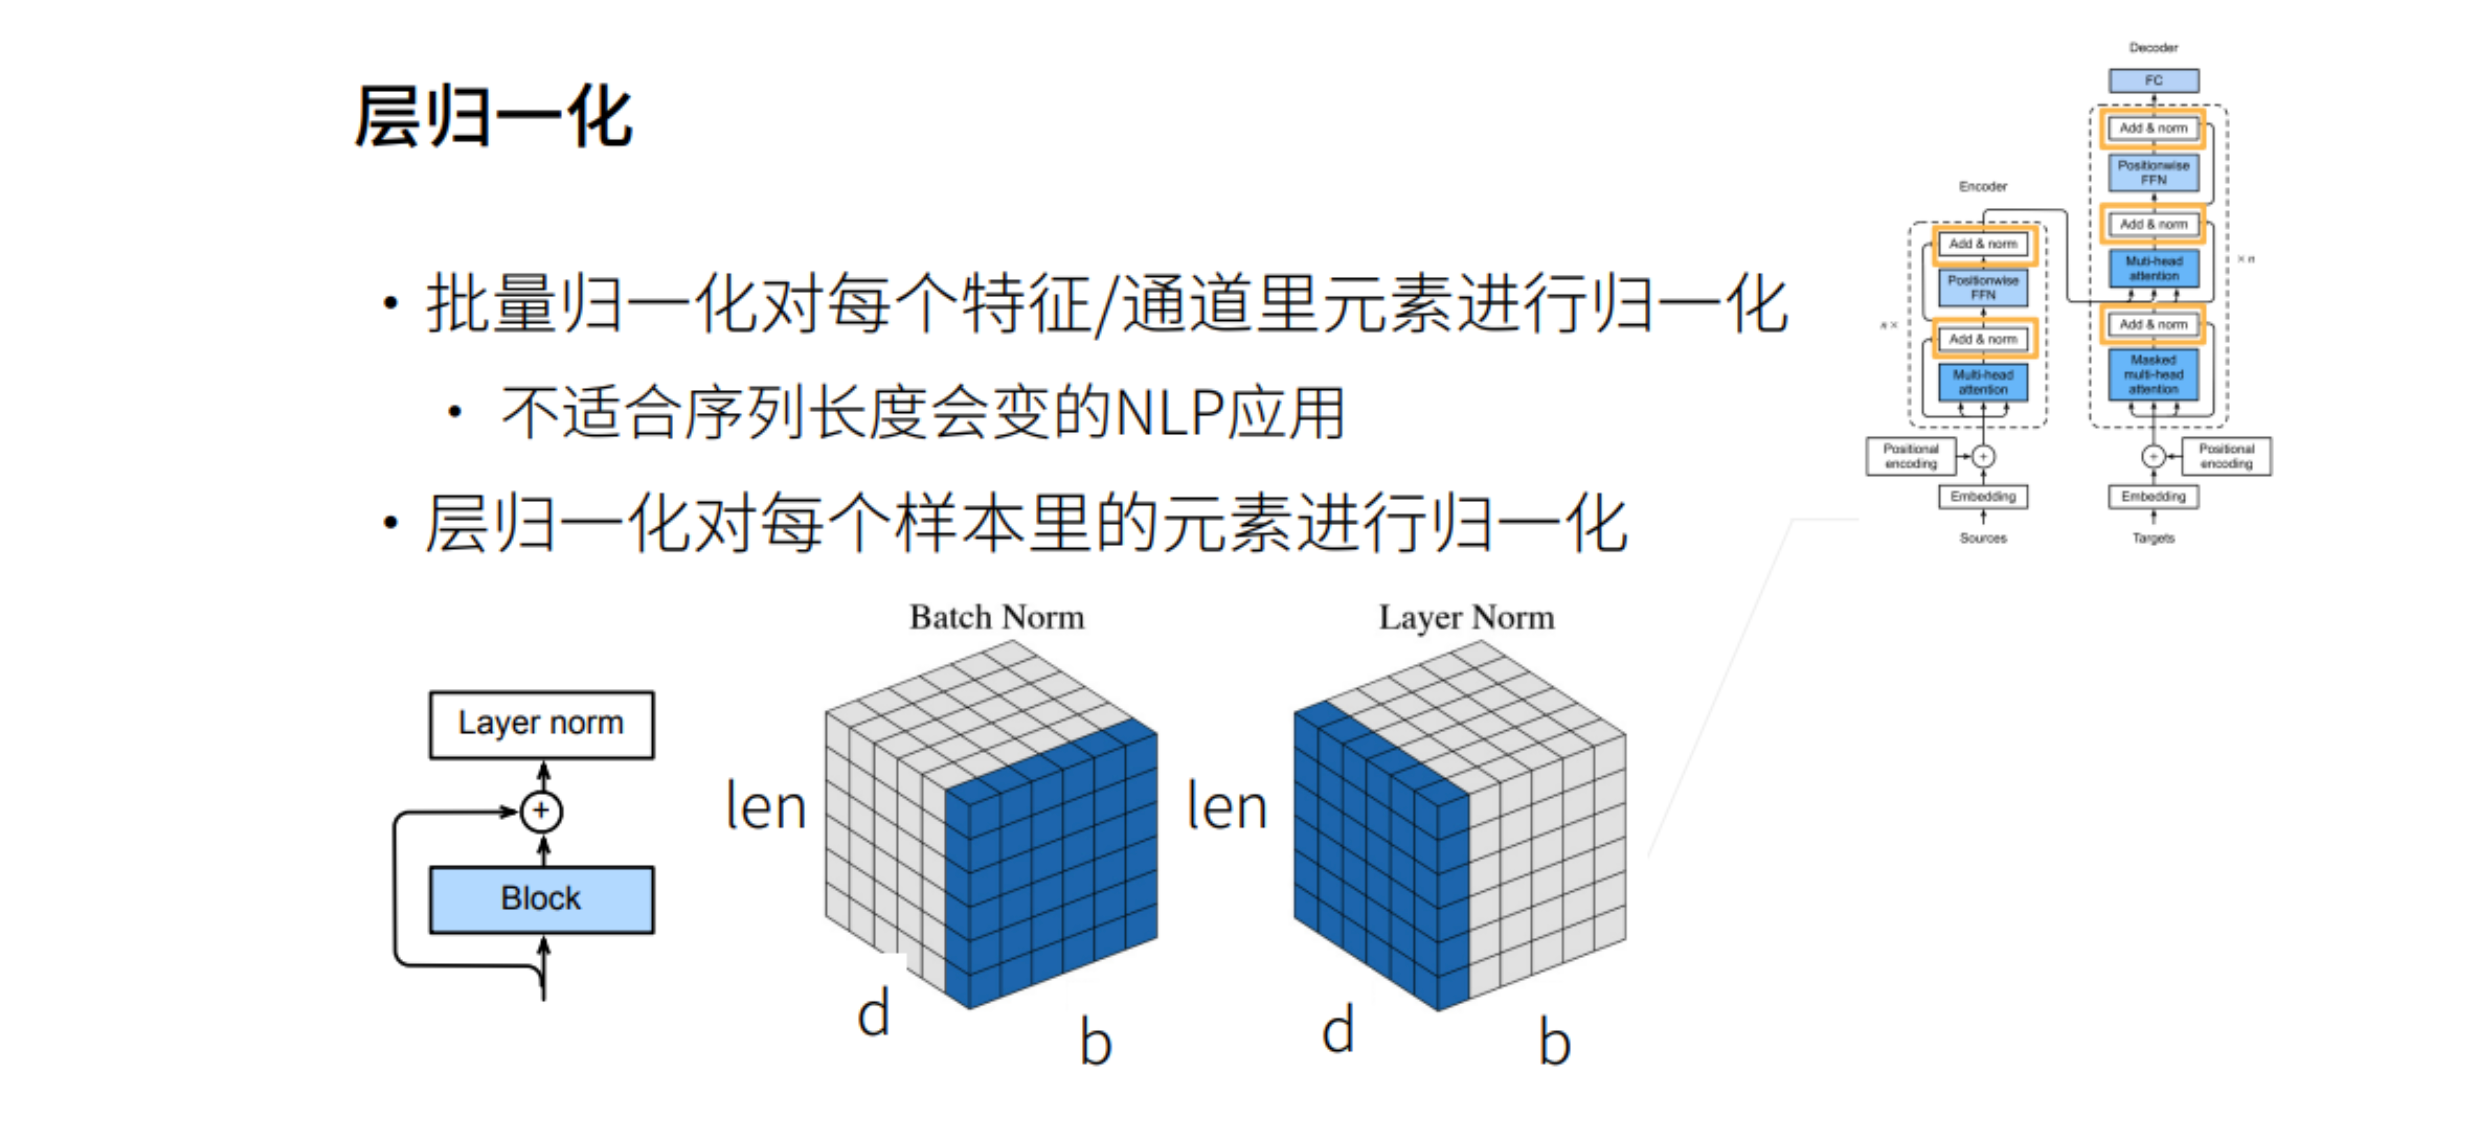
<font color=blue>层归一化的原理
- **计算方式**：对每个样本中的所有元素进行归一化。假设输入张量 $x$ 的形状为 $(b, n, d)$，其中 $b$ 表示批量大小，$n$ 表示序列长度，$d$ 表示特征维度。层归一化会针对每个样本（即每个 $b$ 对应的样本）内的所有元素计算均值和方差，再进行归一化。以第 $i$ 个样本 $x_i$ 为例，其均值 $\mu_i$ 和方差 $\sigma_i^2$ 的计算如下：
\
\begin{align*}
\mu_i &= \frac{1}{nd}\sum_{j = 1}^{n}\sum_{k = 1}^{d}x_{ijk}\\
\sigma_i^2 &= \frac{1}{nd}\sum_{j = 1}^{n}\sum_{k = 1}^{d}(x_{ijk} - \mu_i)^2
\end{align*}
\
然后对该样本进行归一化：
\
\begin{align*}
\hat{x}_{ijk} = \frac{x_{ijk} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}
\end{align*}
\
其中，$\epsilon$ 是一个很小的常数，用于避免分母为零的情况。

<font color=blue>和批量归一化的对比（为什么不使用批量归一化的原因）

- **归一化维度**：
    - **批量归一化（Batch Normalization）**：对每个特征（通道）维度上的元素进行归一化。对于形状为 $(b, n, d)$ 的输入，在 $b$ 和 $n$ 维度上求均值和方差，对每个 $d$ 维度的特征进行归一化操作。
    - **层归一化**：对每个样本内的所有元素进行归一化，即在 $n$ 和 $d$ 维度上求均值和方差，针对每个样本进行归一化。
 - **适用场景**：
    - **批量归一化**：在图像识别等领域应用普遍，对于固定大小的图像输入，能有效加速训练过程，提升模型稳定性。但在自然语言处理等序列长度可变的任务中，由于不同样本的序列长度不一致，其效果会受影响，因为它依赖整个批次的数据来计算均值和方差。 
    - **层归一化**：更适用于自然语言处理等序列长度可变的任务。它不依赖批次数据，**每个样本独立进行归一化**，在处理不同长度的序列时更加灵活、稳定。比如在循环神经网络（RNN）和Transformer中，层归一化被广泛运用。 




#  4 Decoder Block

整体架构：
- 与编码器类似，解码器块也会重复多次，图中显示这些块会重复 6 次（Blocks are also repeated 6 times）。每一个解码器块都会对上一个块的输出进行进一步处理，不断提取和融合信息，逐步生成最终的输出。
- 有两个和编码器不同：Masked self-attention 和 Encoder-decoder attention
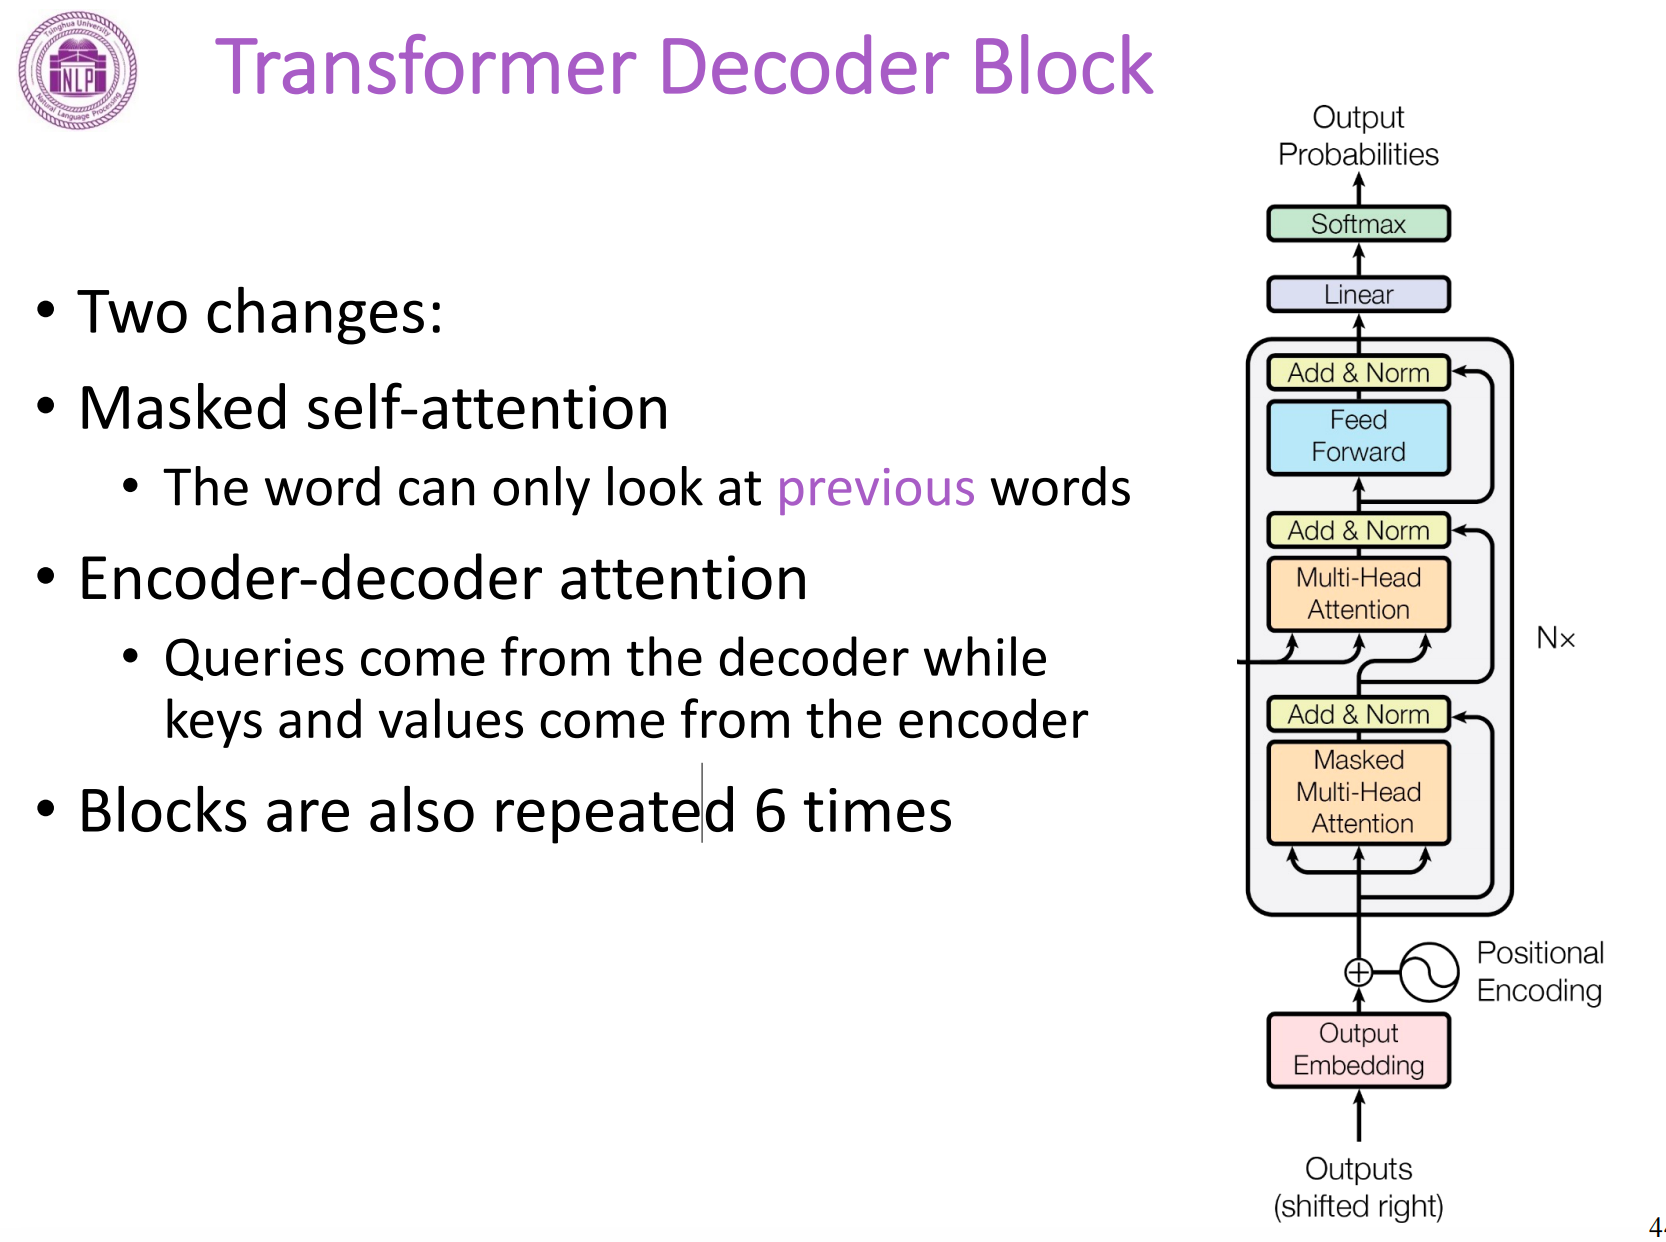

### Masked self-attention：The word can only look at previous words


在Transformer解码器里，生成输出像翻译句子单词时，是逐个进行的。现实中生成当前单词，没法预知后面的单词。所以计算注意力时，不能让模型用该元素之后的信息，不然就和真实生成过程不符，属于不合理的“作弊” 。 为了模拟上述真实的文本生成过程，就需要使用掩码（Mask）操作。
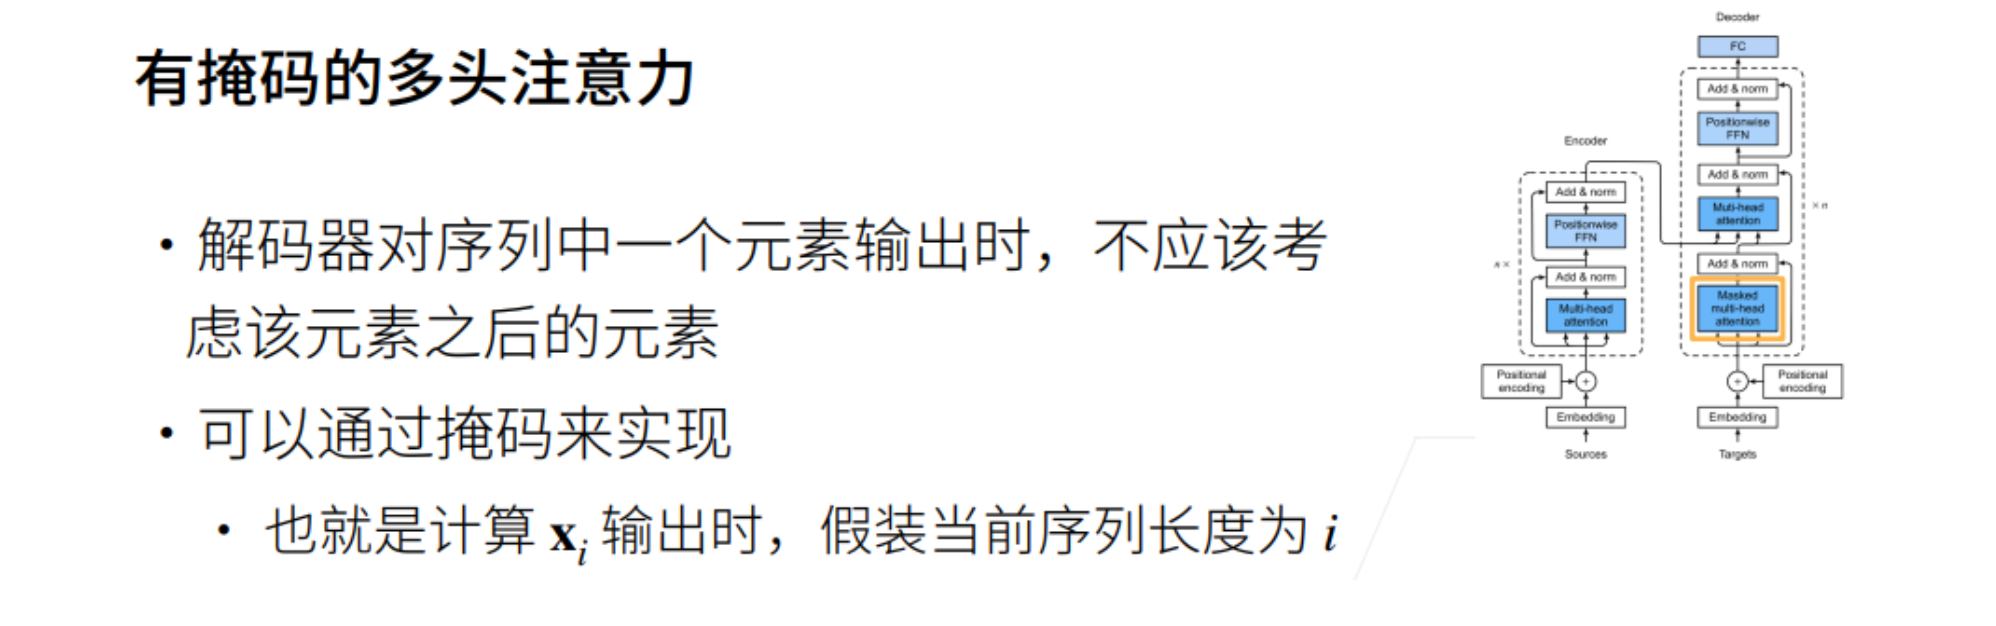

### Encoder-decoder attention

查询（Queries）来自解码器，而键（Keys）和值（Values）来自编码器。这种机制使得解码器能够利用编码器对输入序列提取的特征信息，在生成输出时参考输入序列的内容。
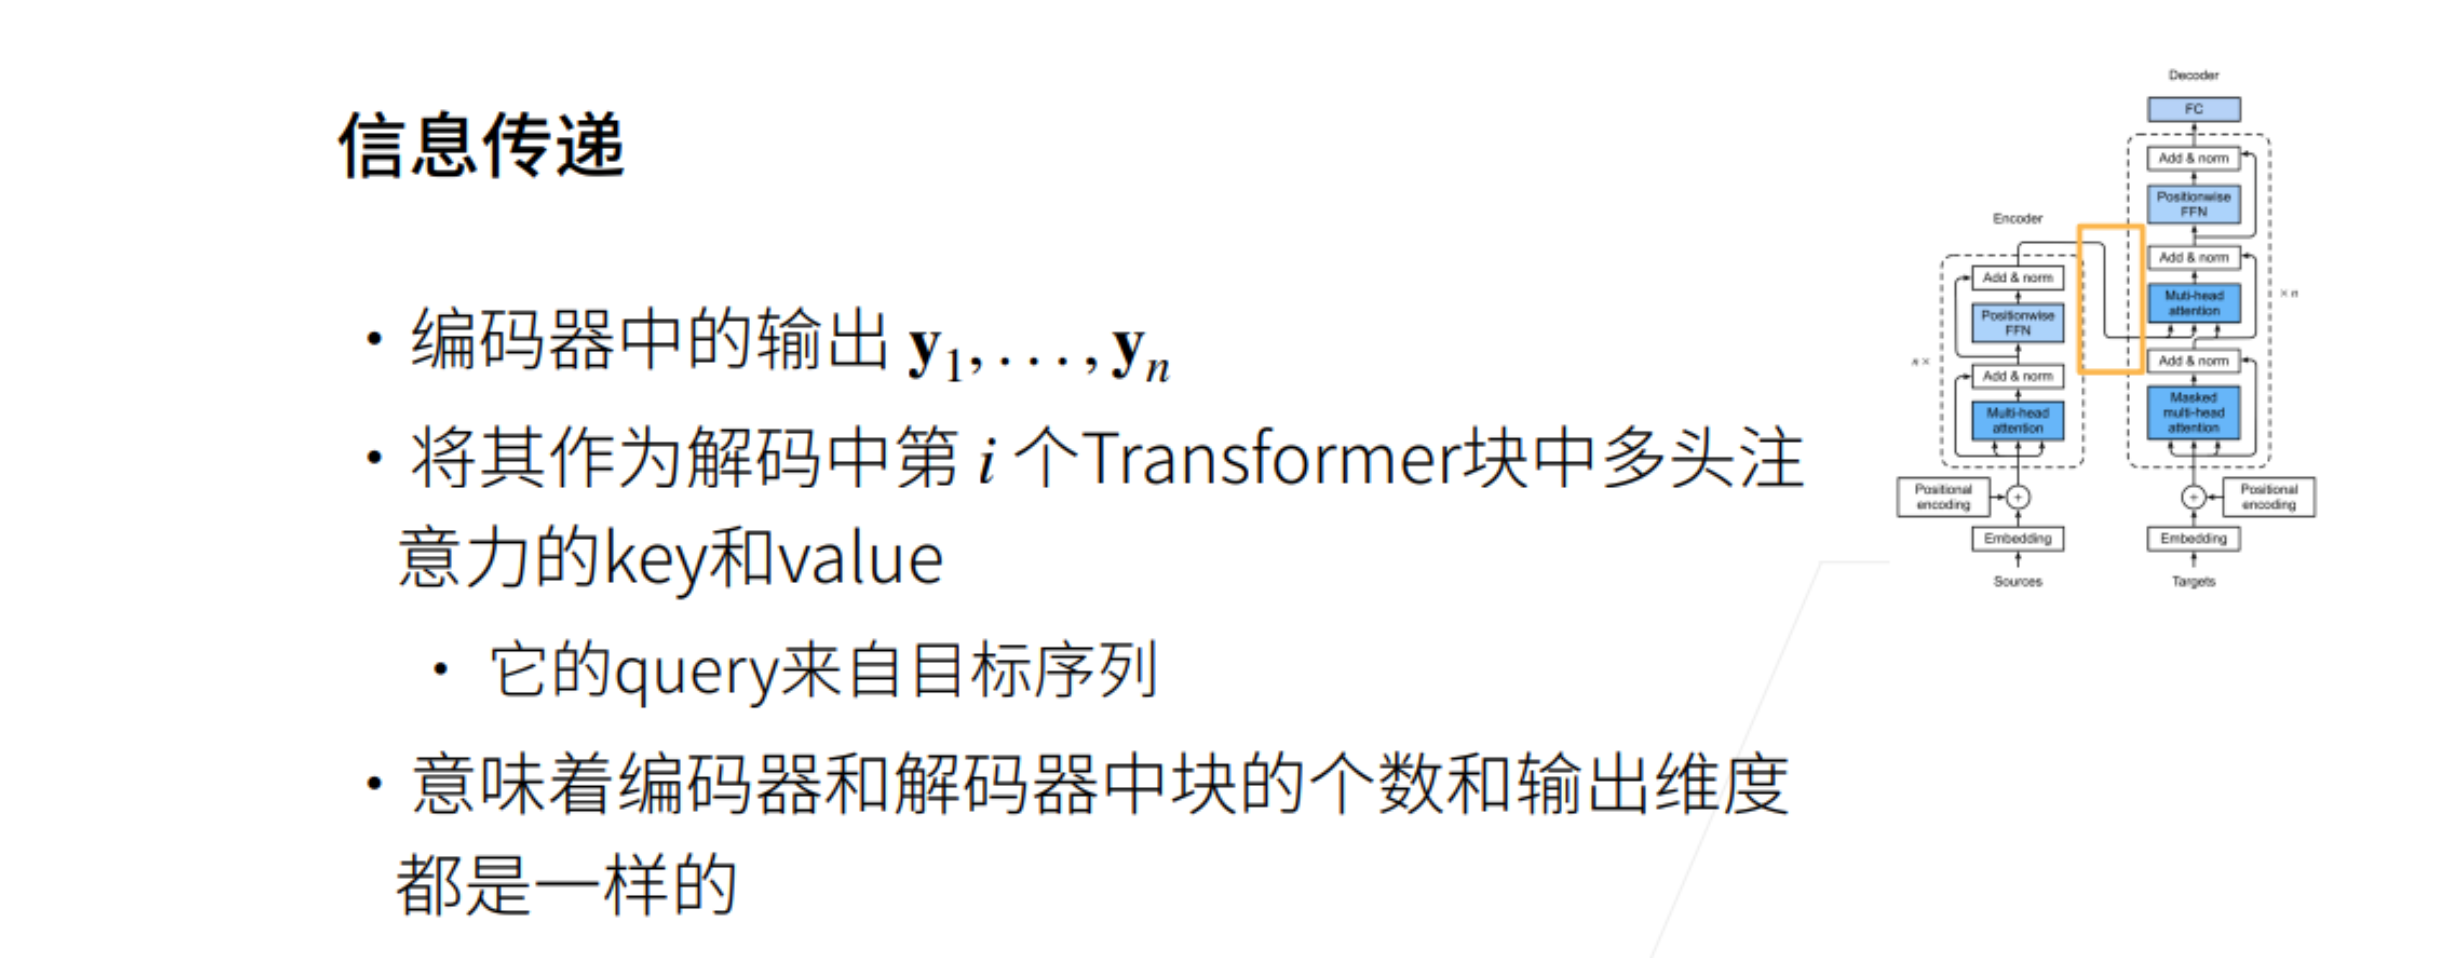


### 预测部分


当要预测第 $t + 1$ 个输出时，解码器的输入是前面已经生成的 $t$ 个预测值。例如在机器翻译中，生成第 $t + 1$ 个目标语言单词时，解码器依据已经生成的前 $t$ 个单词来进行预测。
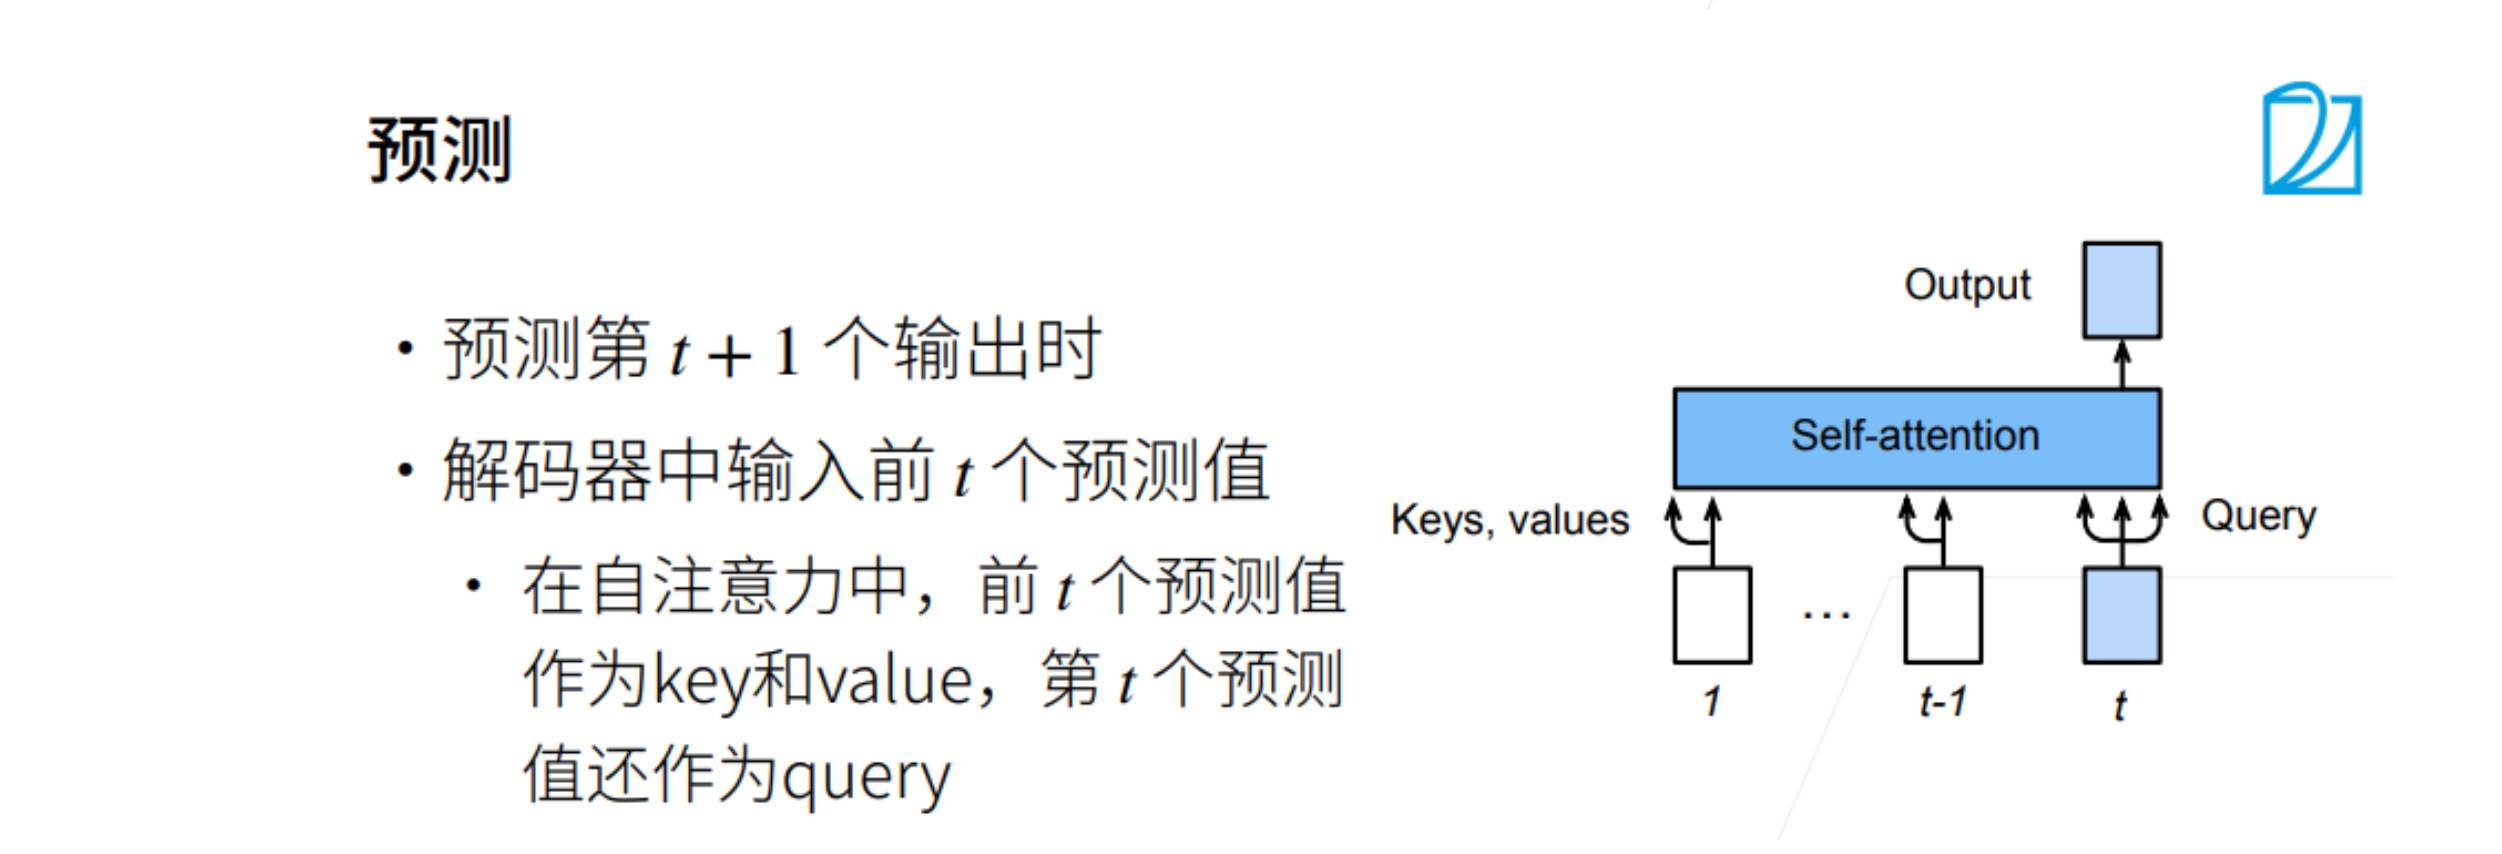


gpt生成）随便看看：
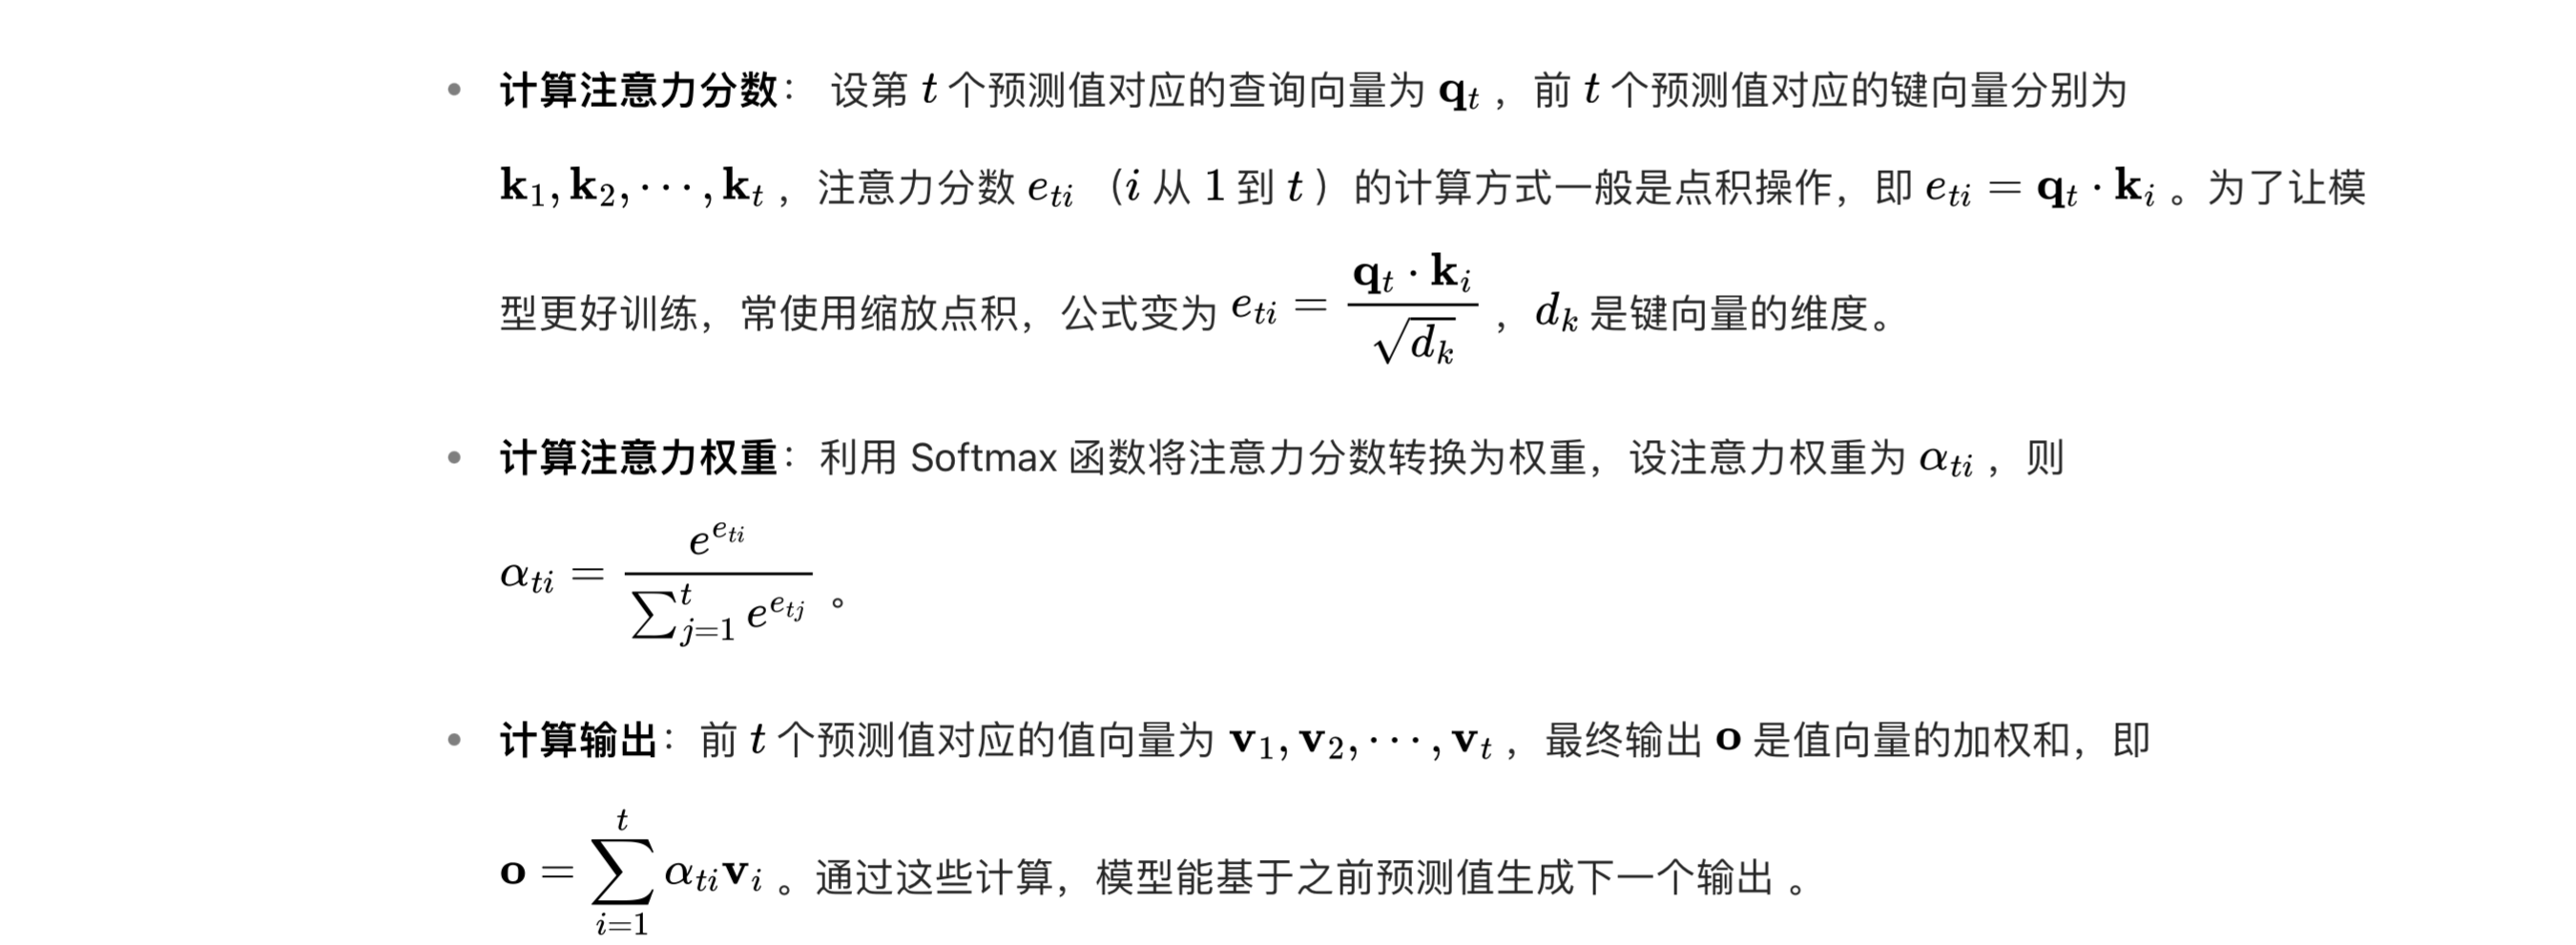

# 代码

## 自注意力

In [11]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
quries_size,num_hiddens, num_heads = 50,100, 5
attention = d2l.MultiHeadAttention(quries_size, quries_size, quries_size,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=50, out_features=100, bias=False)
  (W_k): Linear(in_features=50, out_features=100, bias=False)
  (W_v): Linear(in_features=50, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [13]:
batch_size,num_queries,valid_lens = 2,4,torch.tensor([3,2])
X = torch.ones((batch_size,num_queries,quries_size))
output = attention(X,X,X,valid_lens) # attention(queries, keys, values, valid_lens)
print(output.shape)  # 输出形状: (batch_size, num_queries, quries_size)

torch.Size([2, 4, 100])


## 位置编码

位置编码是 Transformer 架构中的一个重要组件，其主要作用是为输入序列中的每个位置提供位置信息，因为 Transformer 中的自注意力机制本身无法感知序列中元素的顺序，通过位置编码可以让模型学习到序列中元素的相对位置关系。

这部分代码 以及 定义都不是很懂。。。这个正余弦函数到底啥意思

## transformer
<font color=brown>**Transformer编码器中的任何层都不会改变其输入的形状。**

In [14]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

FFN 前馈神经网络
- ffn_num_input
它表示输入特征的维度，也就是输入到前馈网络中每个元素的特征数量。在 Transformer 架构里，这个维度通常和多头注意力机制的输出维度保持一致，因为基于位置的前馈网络一般是紧跟在多头注意力层之后的。
- ffn_num_outputs
它表示输出特征的维度，也就是前馈网络最终输出的每个元素的特征数量。
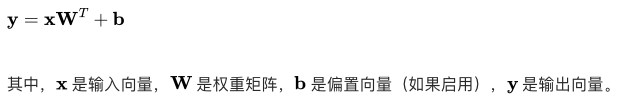

- 输入张量维度通常为 `(batch size, sequence length, ffn_num_input)`：
- 输出张量维度通常为 `(batch size, sequence length, ffn_num_outputs)`：



In [32]:
class PositionWiseFFN(nn.Module):
    def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,**kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input,ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens,ffn_num_outputs)
    def forward(self,X):
        return self.dense2(self.relu(self.dense1(X)))


AddNorm
- nn.LayerNorm(normalized_shape) normalized_shape：要实行标准化的最后 D 个维度
- self.dropout(Y) + X：执行残差连接操作，将经过 Dropout 处理后的 Y 与原始输入 X 相加。残差连接的作用是让模型可以学习到输入的残差部分，使得模型更容易优化，并且有助于缓解梯度消失问题。注意残差连接要求两个输入X,Y的形状相同，以便加法操作后输出张量的形状相同。

In [30]:
class AddNorm(nn.Module):
    def __init__(self,normalized_shape,dropout,**kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self,X,Y):
        return self.ln(self.dropout(Y)+X)

In [31]:
addnorm = AddNorm([3,4],0.5)
output = addnorm(torch.randn([2,3,4]),torch.ones((2, 3, 4)))  # (batch_size, seq_len, feature_dim)
output.shape

torch.Size([2, 3, 4])

encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddN-orm(norm_shape, dropout)
    def forward(self,X,valid)